In [1]:
import tensorflow as tf
import numpy as np

In [2]:
HISTORY_TIMES = [3, 7, 15, 31, 47, 63, 95, 127]

PIECES = 256

In [3]:
tf.reset_default_graph()

# Training Parameters
learning_rate = 0.01
batch_size = 125
voices = 7
epsilon = 1e-06

# Network Parameters
num_input = 88 * len(HISTORY_TIMES) + 88       # dimension of one input at moment
num_hidden = 300     # num of lstms in first hidden layer
#num_hidden2 = 100    # num of lstms in second hidden layer
#num_hidden3 = 150    # num of lstms in second hidden layer
num_output = 88      # output dimension

# tf graph input
X = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, num_input])

lstm = tf.contrib.rnn.MultiRNNCell([
    tf.contrib.rnn.LSTMCell(num_hidden, forget_bias=1.0),
    #tf.contrib.rnn.LSTMCell(num_hidden2, forget_bias=1.0),
    #tf.contrib.rnn.BasicLSTMCell(num_hidden3, forget_bias=1.0)
])

lstm_outputs, _ = tf.nn.dynamic_rnn(lstm, X[:, :-1], dtype=tf.float32)

ans = tf.layers.dense(lstm_outputs, (num_output+1)*voices, activation=None)

voices_proba = []
p = tf.zeros([batch_size, tf.shape(X)[1] - 1, (num_output+1)], dtype=tf.float32)
neg_p = tf.ones([batch_size, tf.shape(X)[1] - 1, (num_output+1)], dtype=tf.float32)
for v in range(voices):
    voices_proba.append(tf.nn.softmax(ans[:, :, v*(num_output+1):(v+1)*(num_output+1)], dim=2))
    p += neg_p * voices_proba[-1]
    neg_p *= (1 - voices_proba[-1])

clip_p = tf.clip_by_value(p[:, :, :-1], epsilon, 1 - epsilon)

ce = -tf.log(clip_p) * X[:, 1:, :num_output] - tf.log(1 - clip_p) * (1 - X[:, 1:, :num_output])
loss_op = tf.reduce_mean(ce)

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08,
                                   use_locking=False,
                                   name='Adam')
gvs = optimizer.compute_gradients(loss_op)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)

#optimizing
#train_op = tf.contrib.layers.optimize_loss(
#                loss_op, tf.train.get_global_step(), optimizer=optimizer, learning_rate=learning_rate)

init = tf.global_variables_initializer()

In [4]:
# Start training
config = tf.ConfigProto(log_device_placement=True, device_count = {'GPU': 0})  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.6  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)
sess = tf.Session(config = config)
saver = tf.train.Saver()

In [5]:
# Run the initializer
sess.run(init)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def drawNotes(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.shape[0] / 10, song.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.imshow(song.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.shape[0], 4))
    plt.show()

In [7]:
songs = np.load("CM_dataset.npy")

In [8]:
def transform(song, stack_zeros=True):    
    wh = song.copy()
    for t in HISTORY_TIMES:
        h = np.roll(song, t, axis=0)
        h[:, :t] = 0
        wh = np.concatenate([wh, h], axis=1)
    
    return wh

hsongs = []
for song in songs:
    t = transform(song)
    for i in range(0, t.shape[0] - PIECES, 32):
        hsongs.append(t[i:i+PIECES])
hsongs = np.array(hsongs)

0.0217469  mean for last:  0.0217469


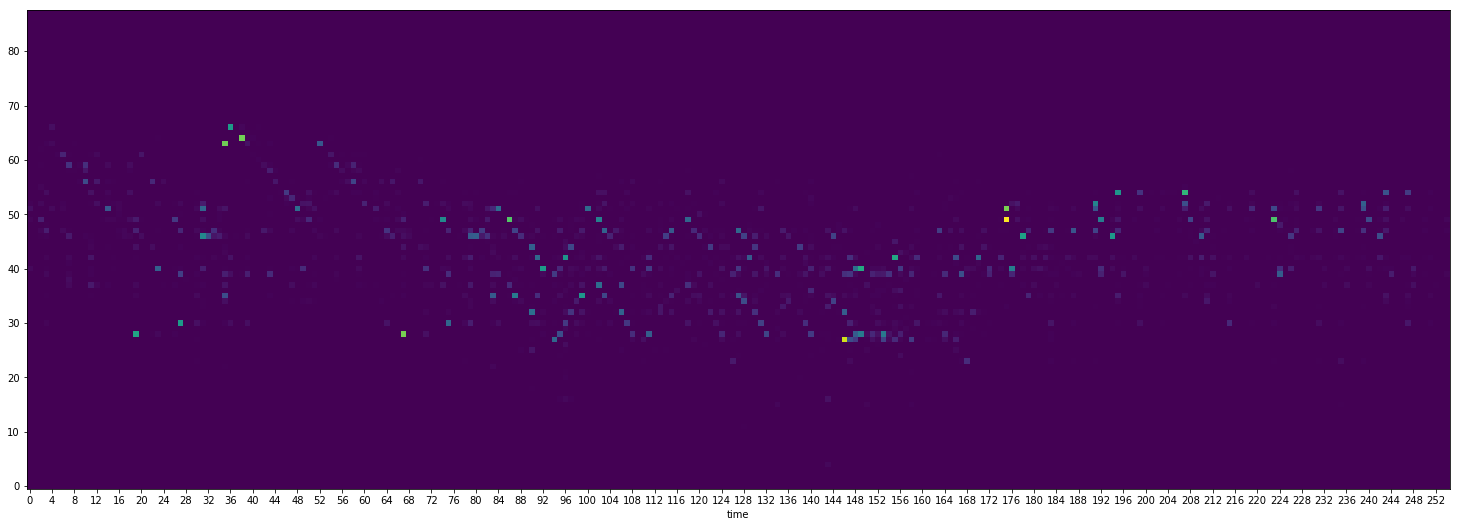

0.0201197  mean for last:  0.0204325


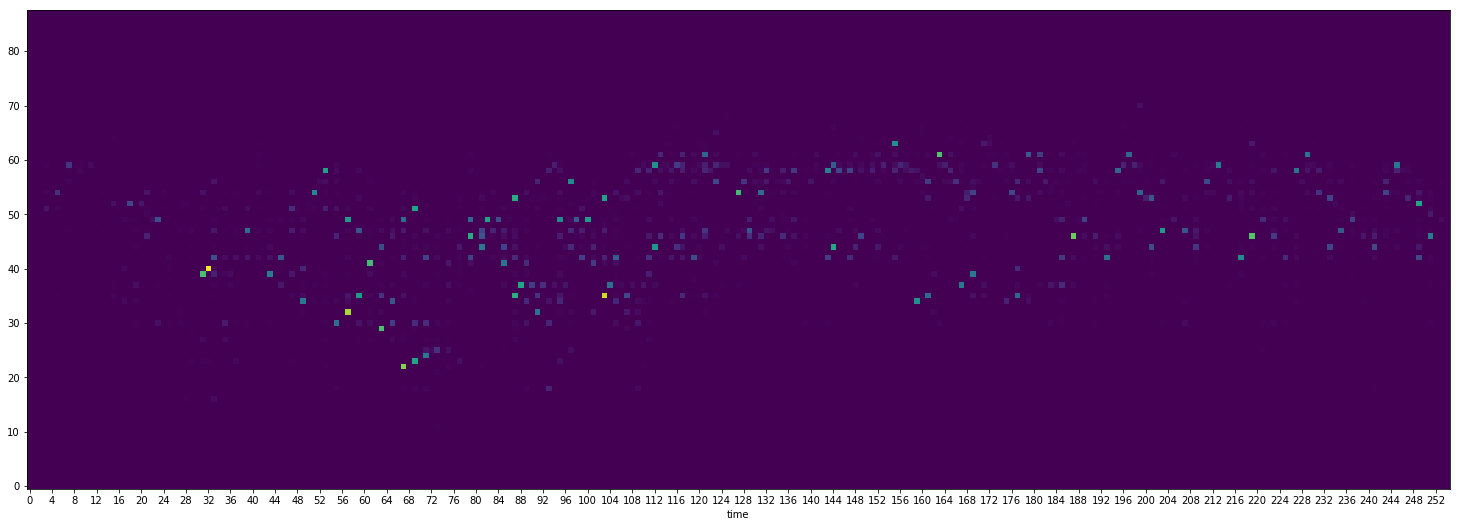

0.0199211  mean for last:  0.0194379


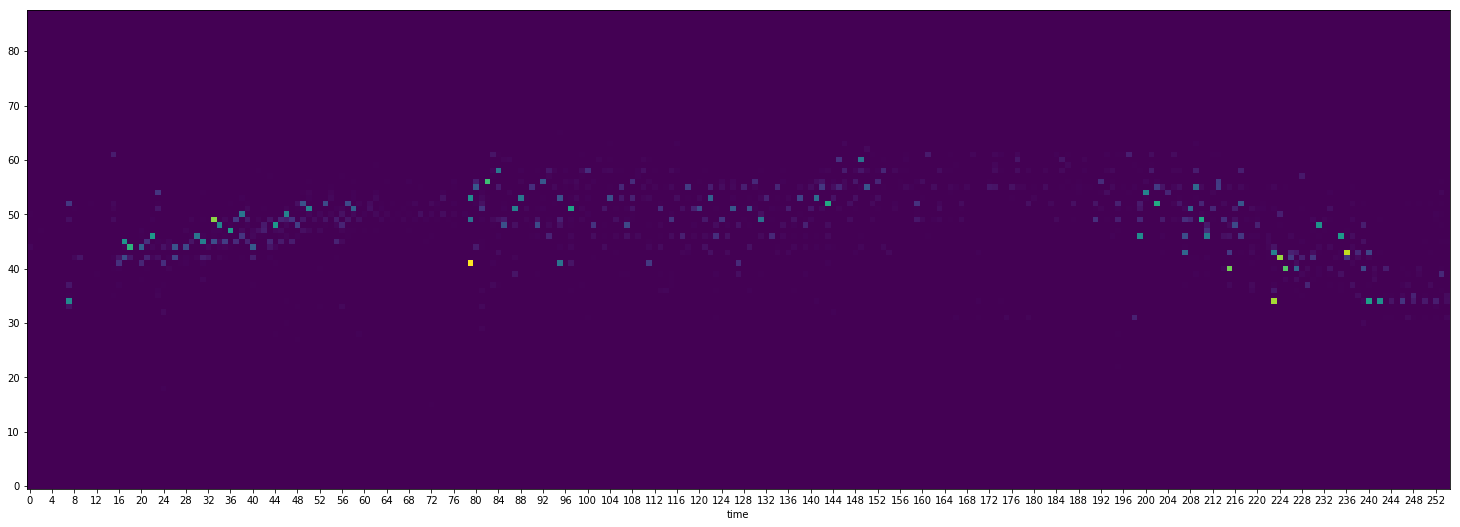

0.0186329  mean for last:  0.0190584


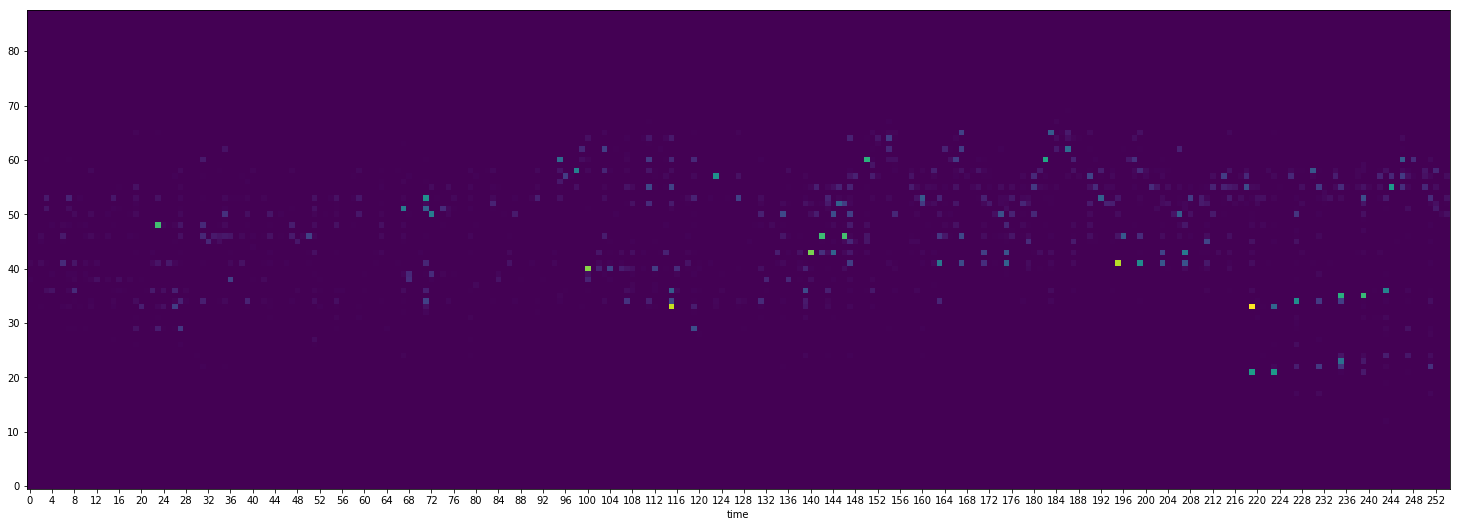

0.0176458  mean for last:  0.0187106


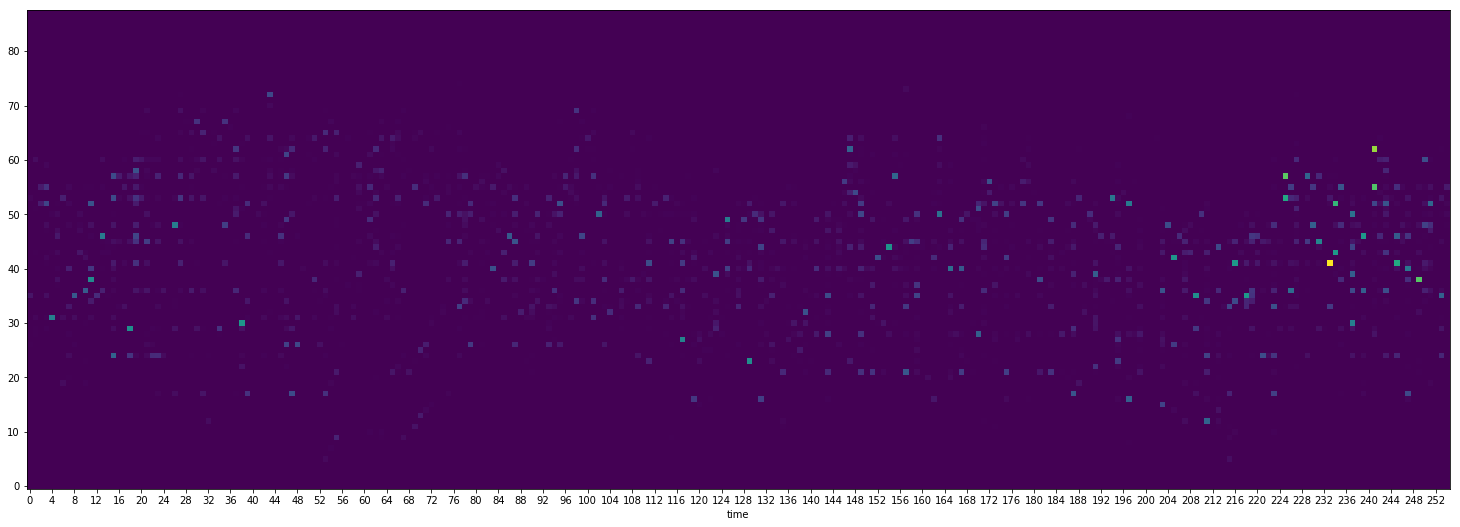

0.0174094  mean for last:  0.0177142


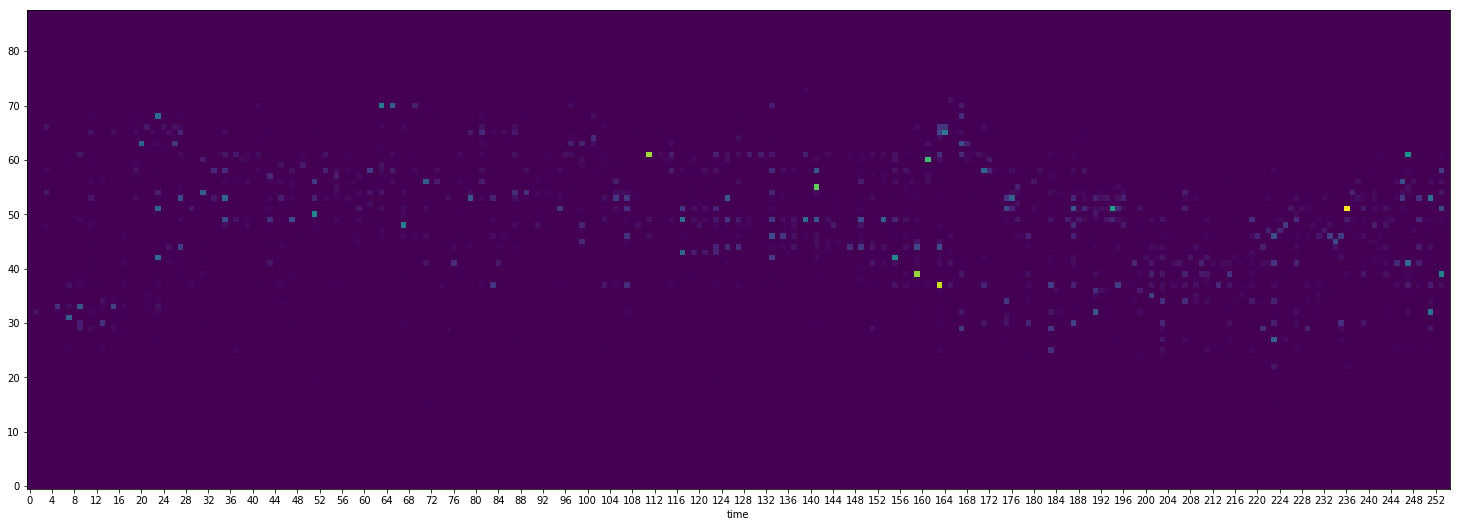

0.0172969  mean for last:  0.0172431


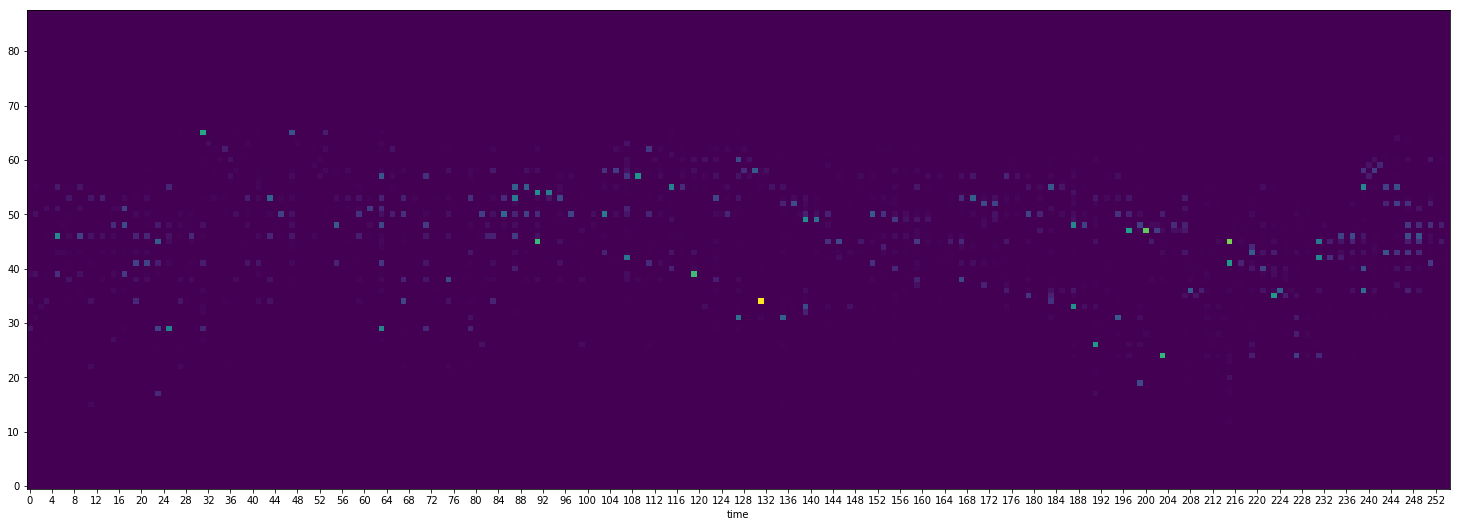

0.0160363  mean for last:  0.0165576


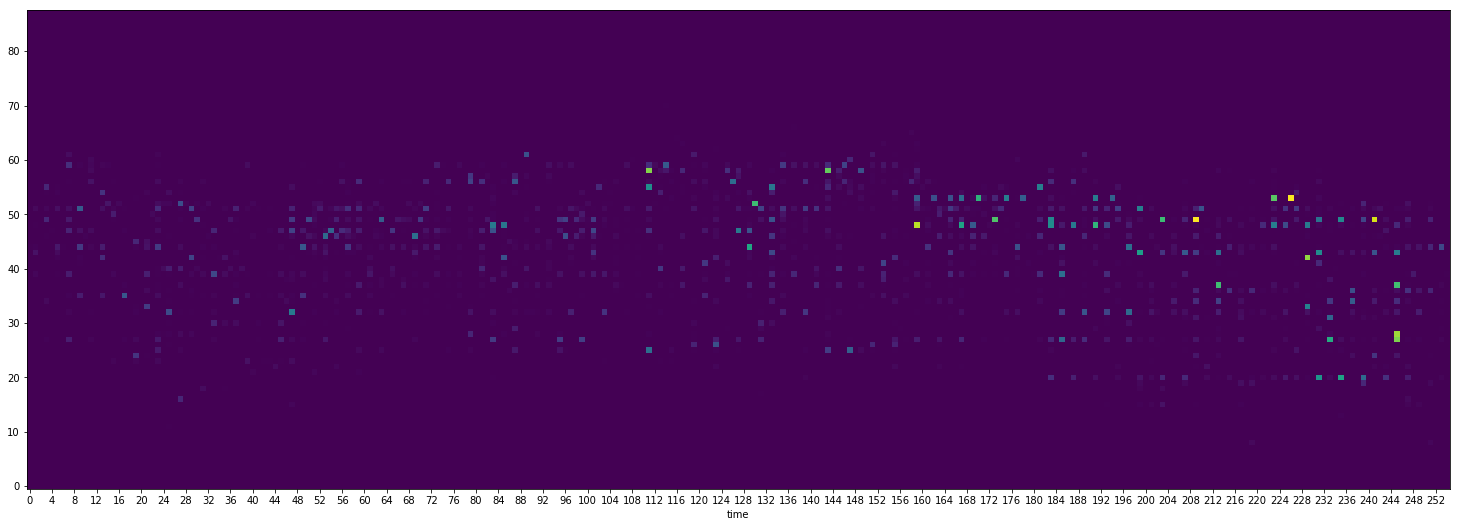

0.0163278  mean for last:  0.0161768


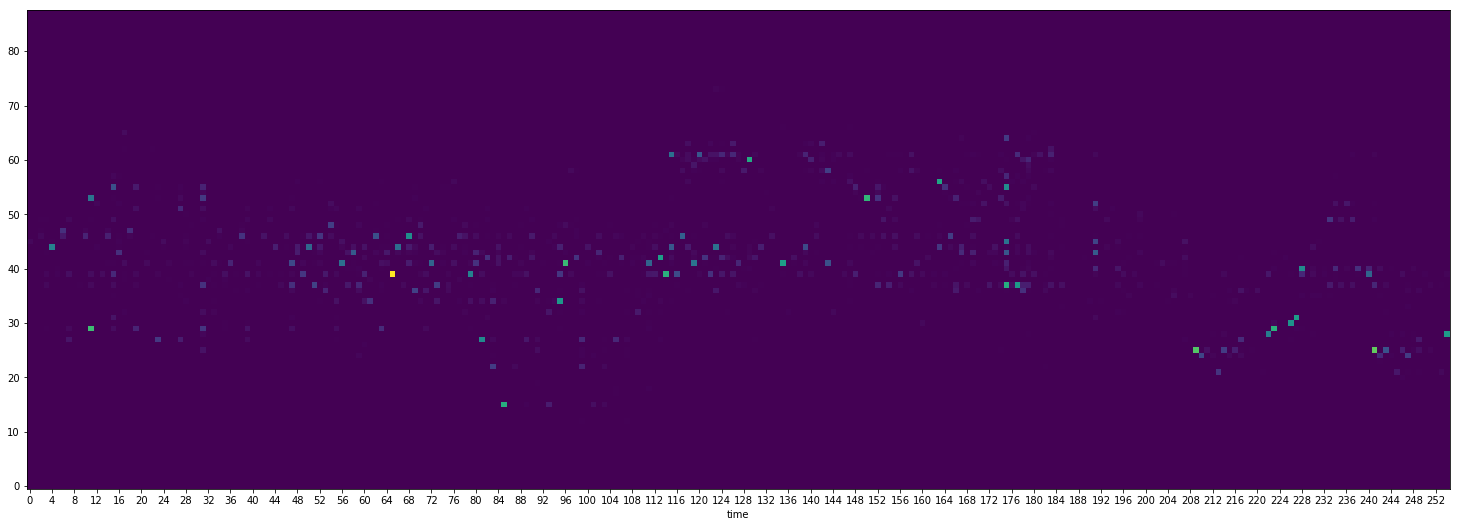

0.0151854  mean for last:  0.015448


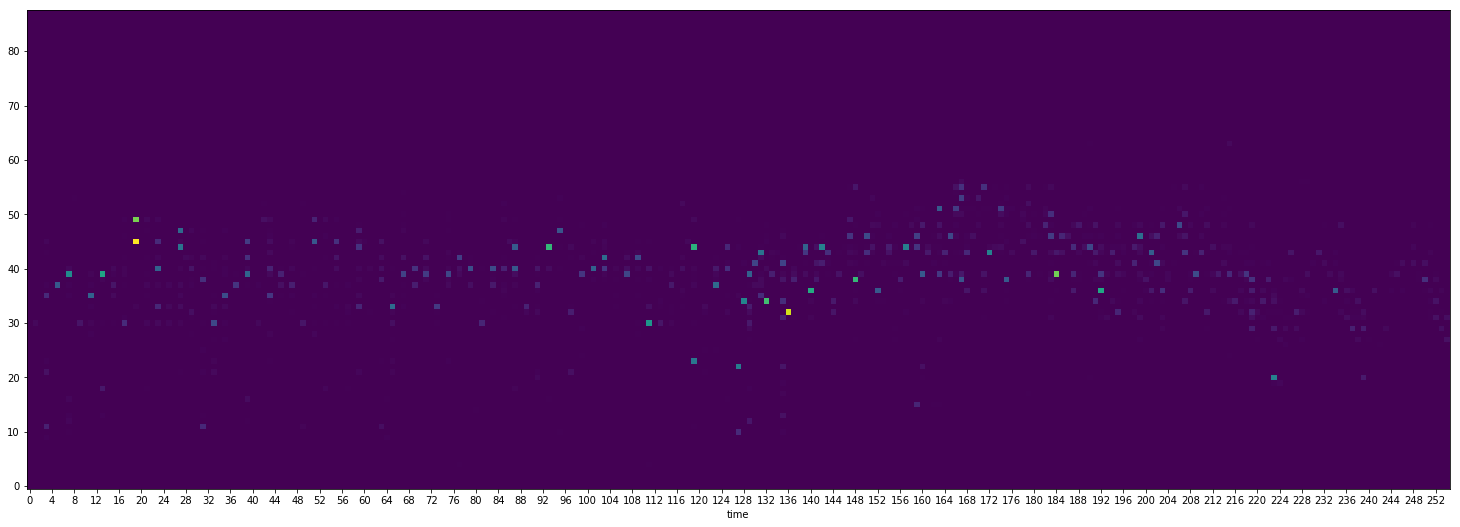

0.014584  mean for last:  0.0153444


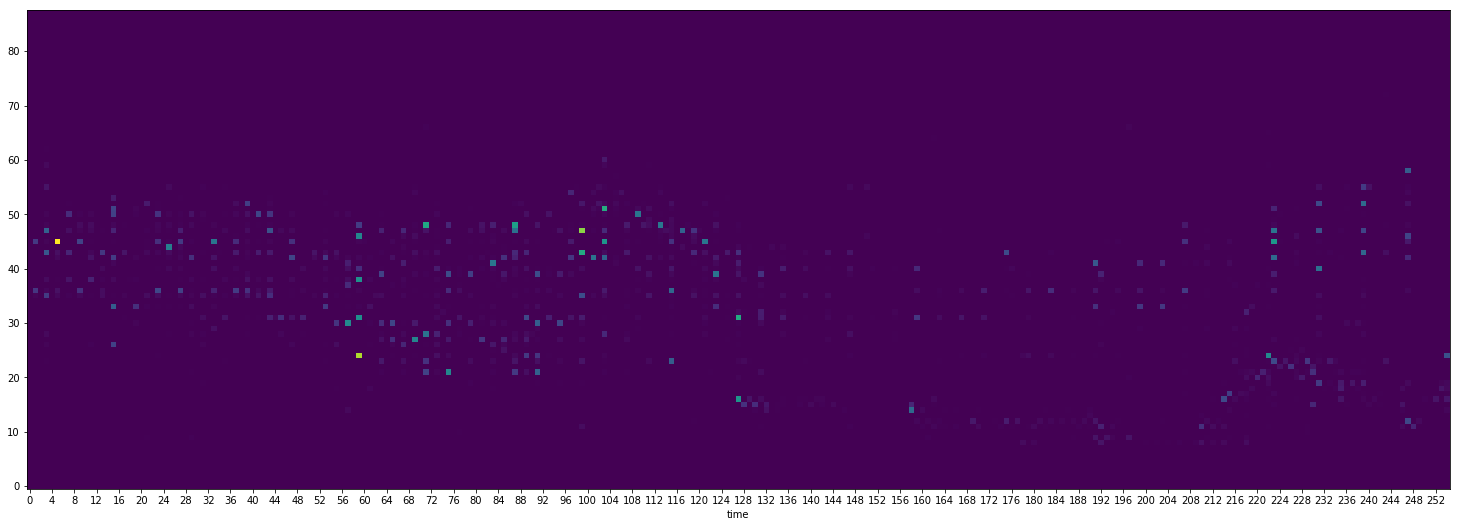

0.0143087  mean for last:  0.0147429


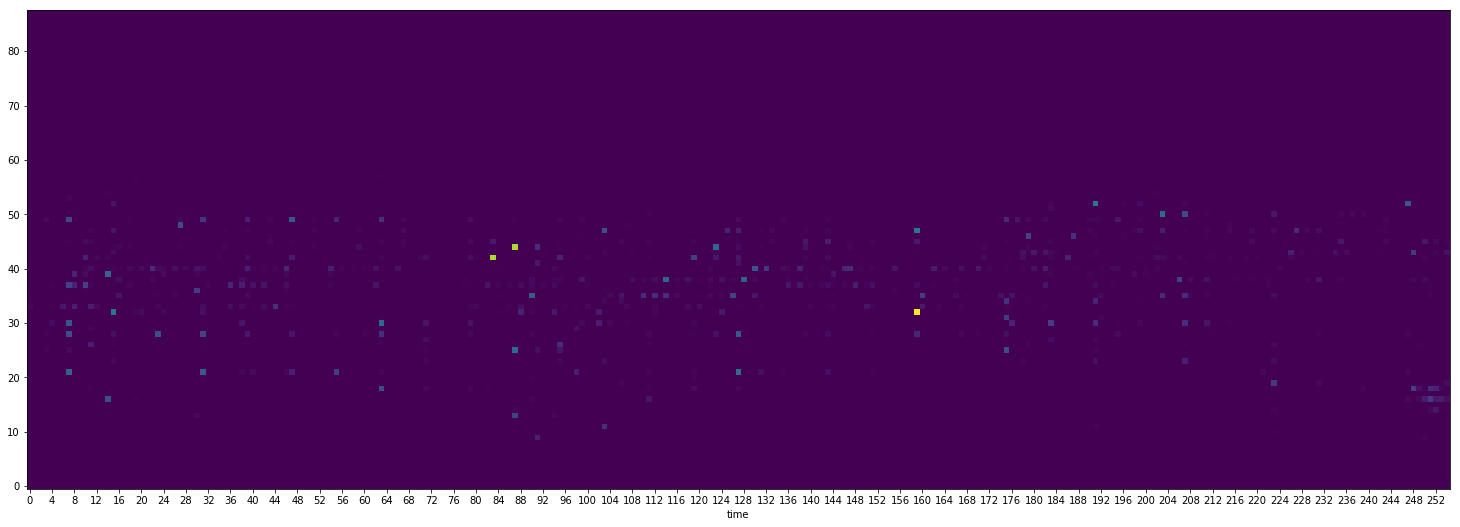

0.0134679  mean for last:  0.0142353


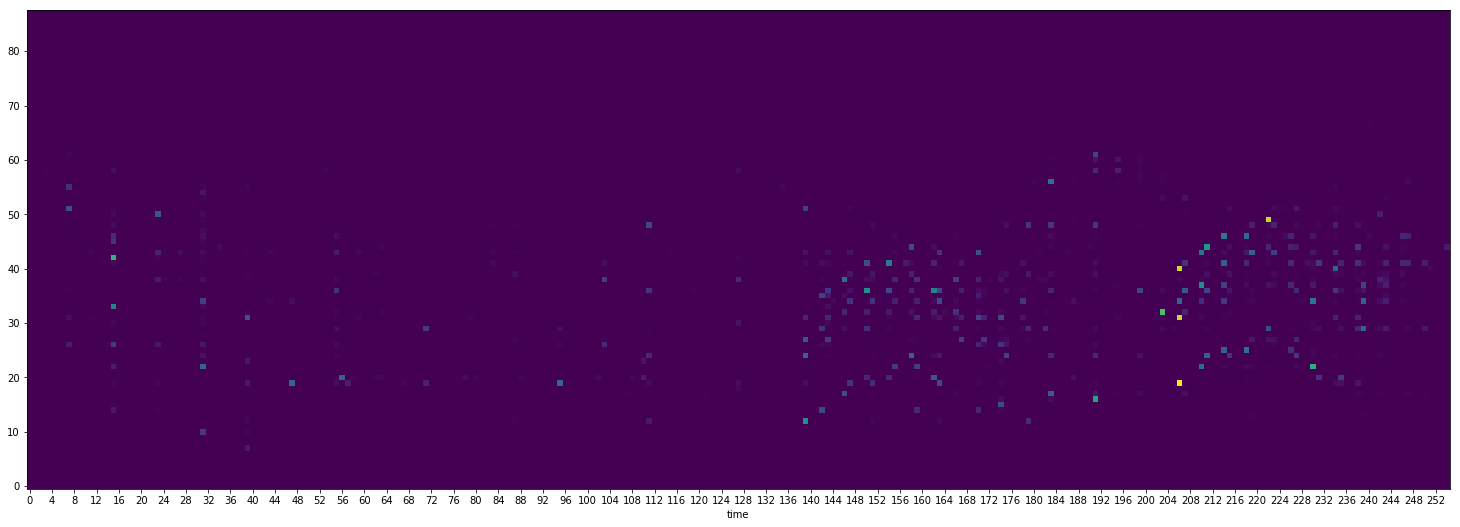

0.0138302  mean for last:  0.0139602


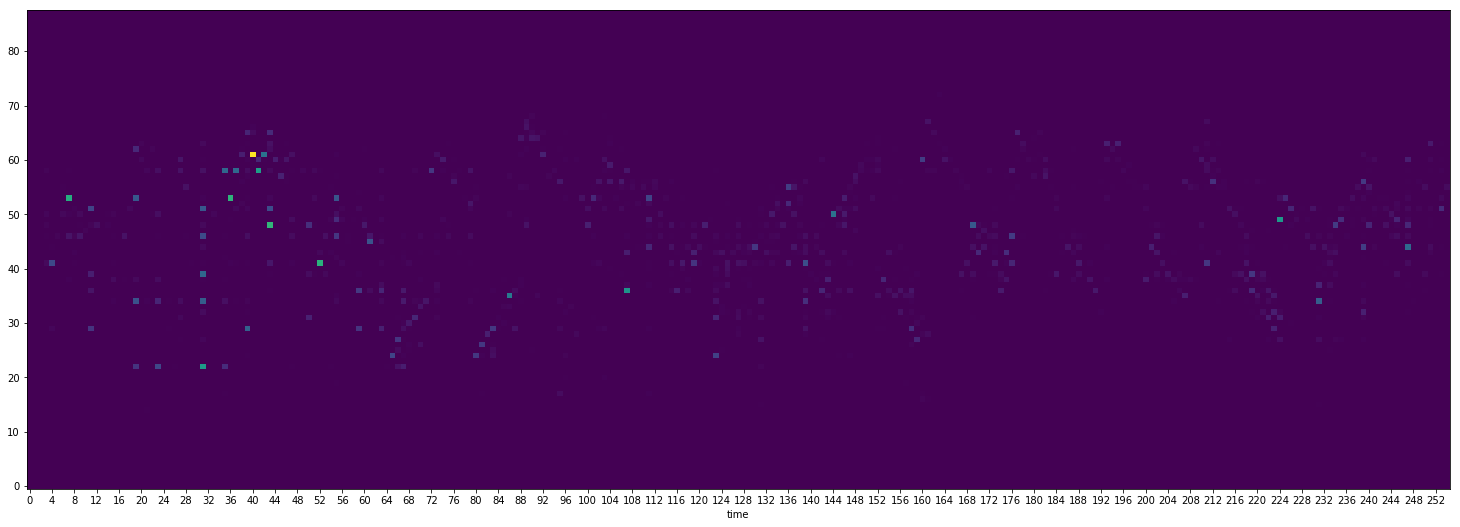

0.0124093  mean for last:  0.0132295


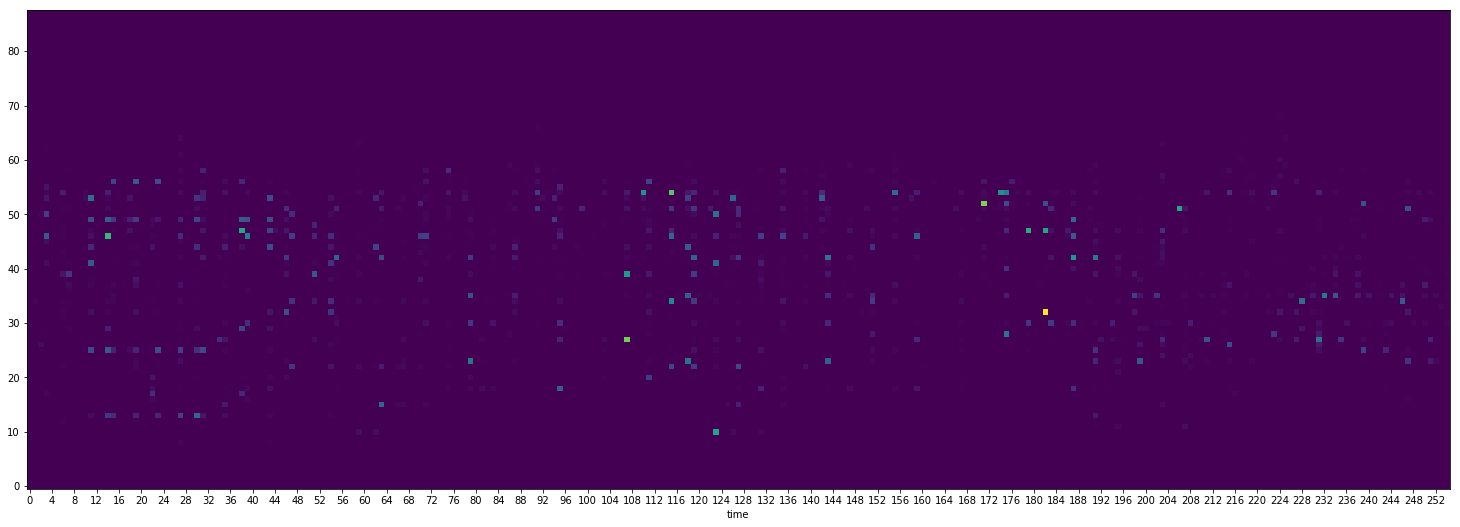

0.012642  mean for last:  0.0127607


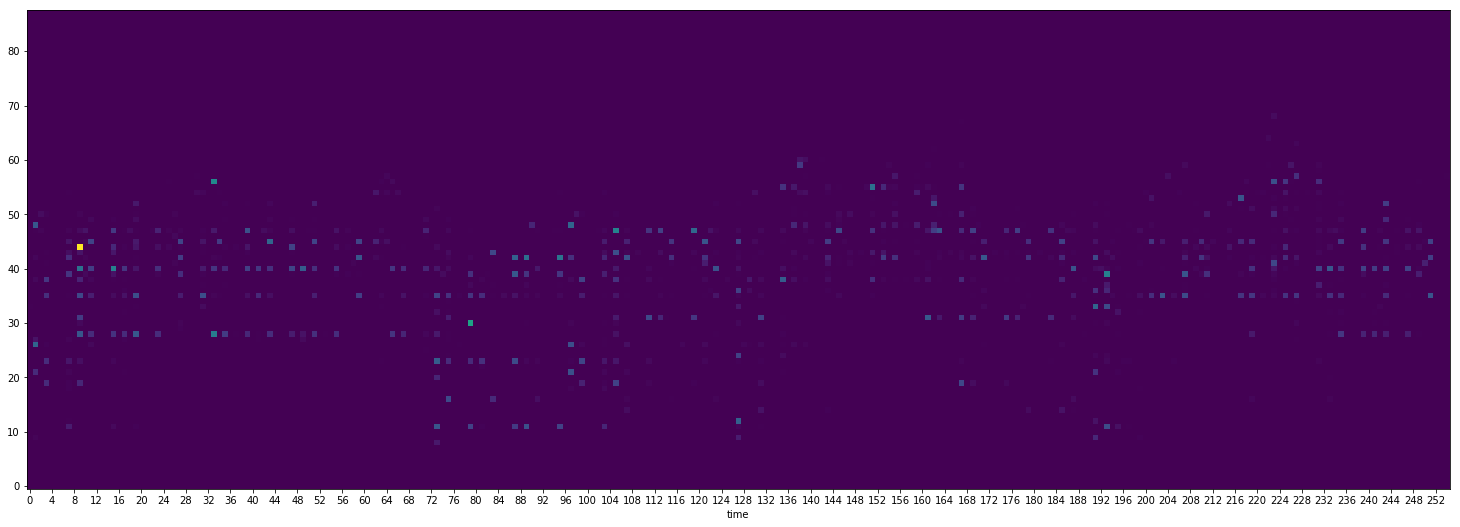

0.012337  mean for last:  0.0125303


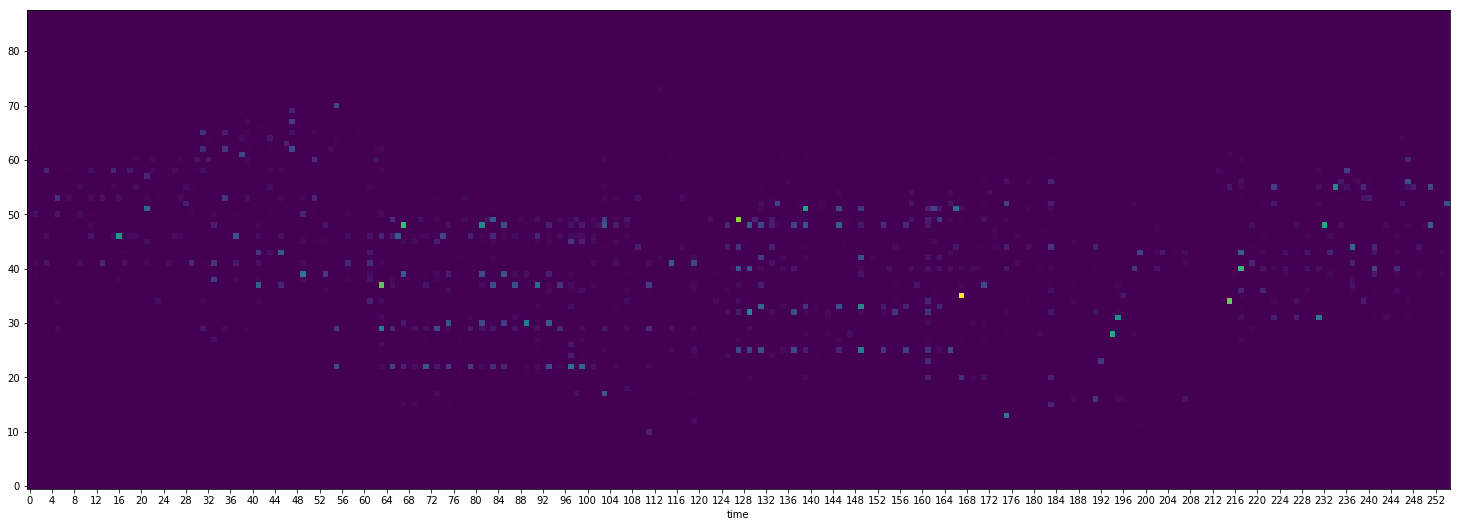

0.0129669  mean for last:  0.0125235


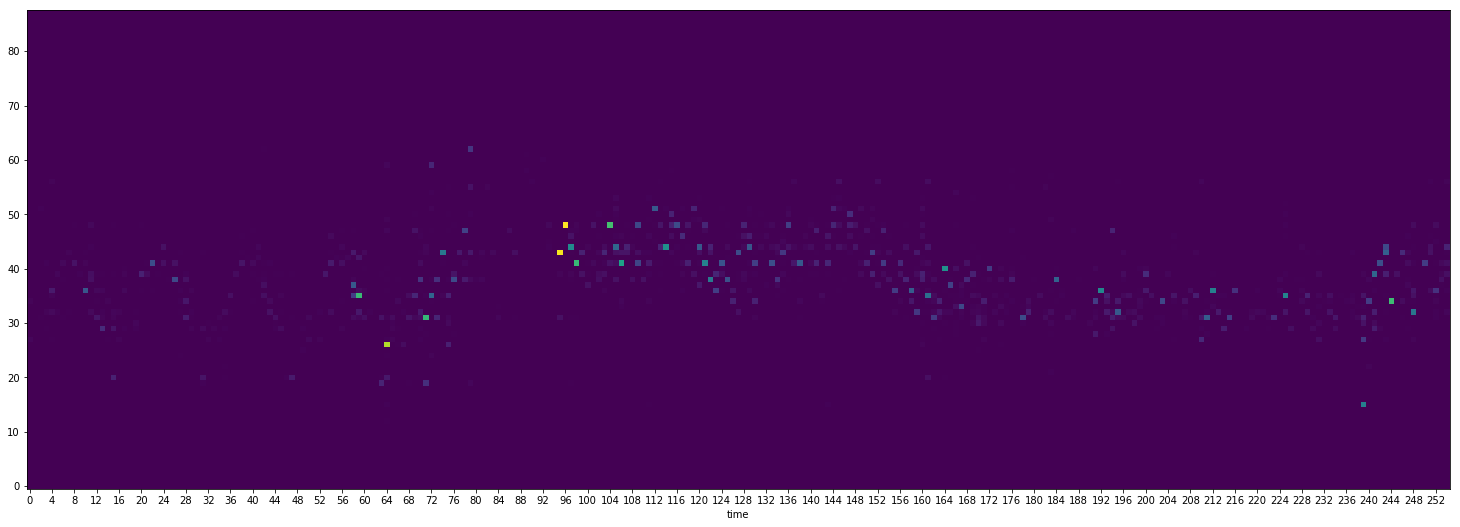

0.0113525  mean for last:  0.011869


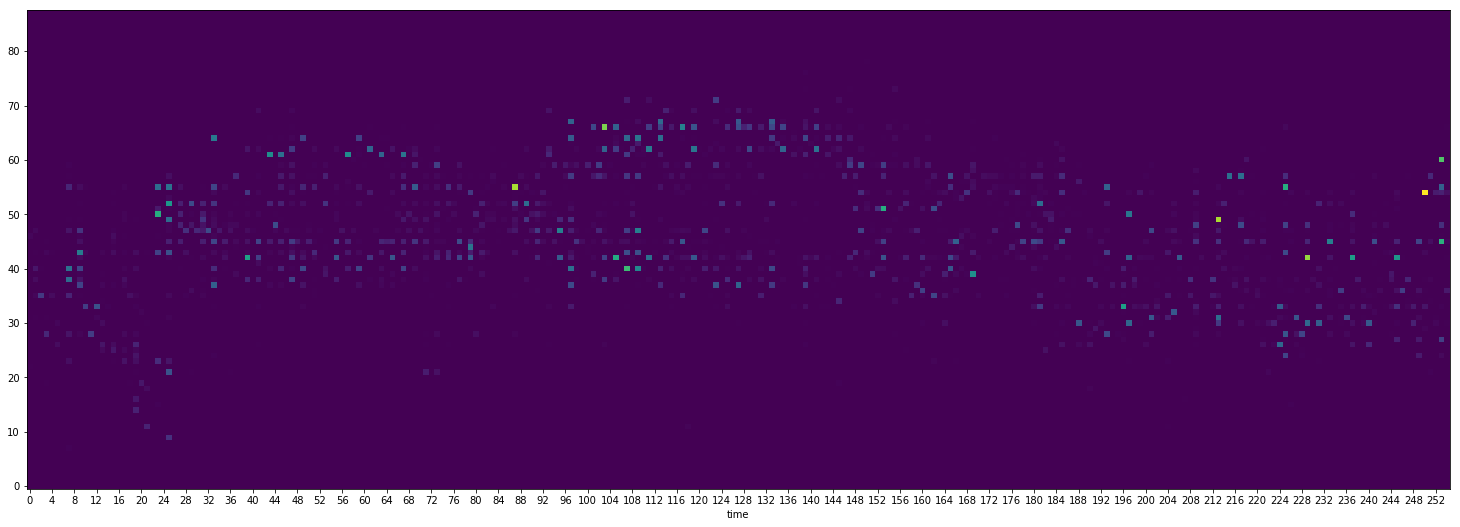

0.0113407  mean for last:  0.0114342


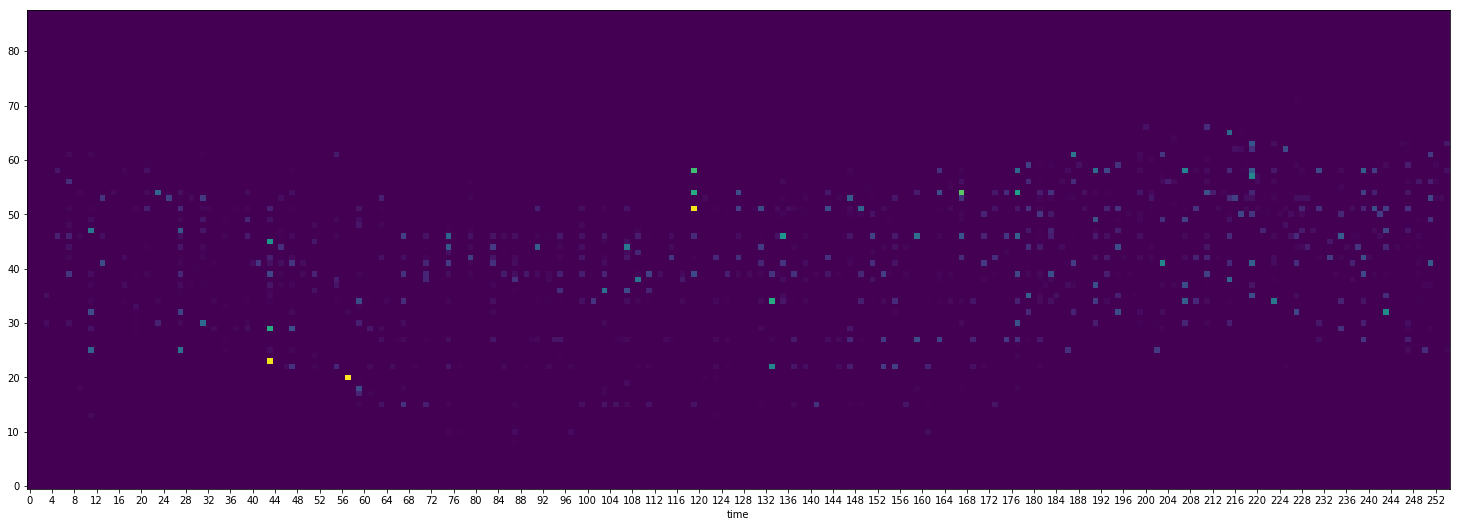

0.0109727  mean for last:  0.0113442


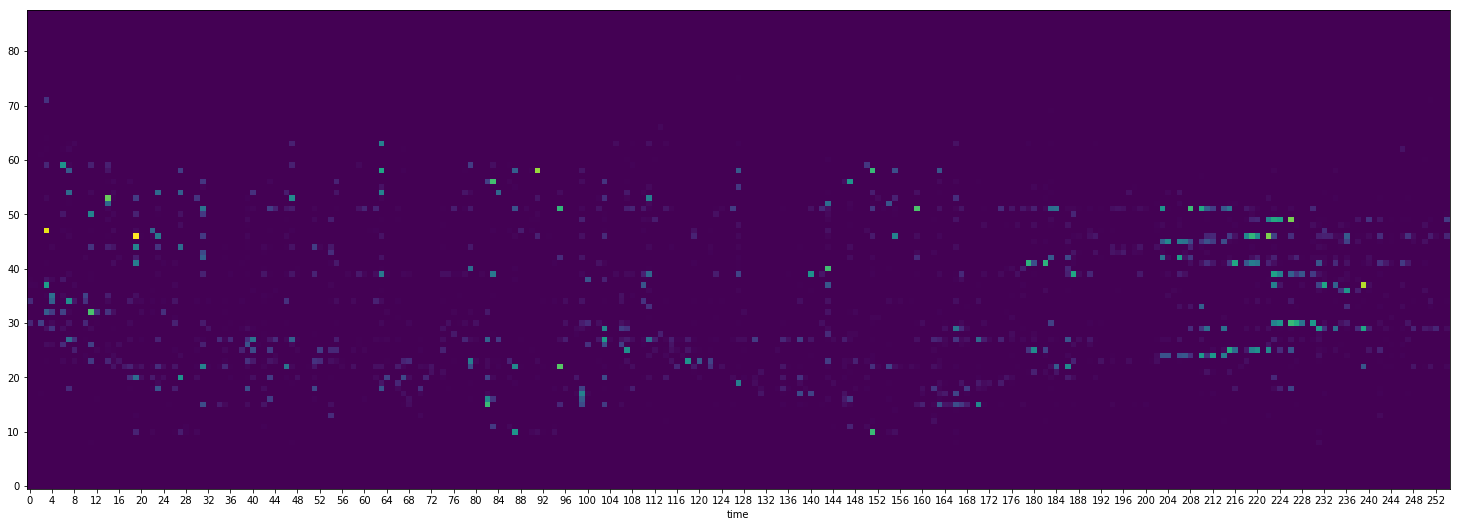

0.00913151  mean for last:  0.0107607


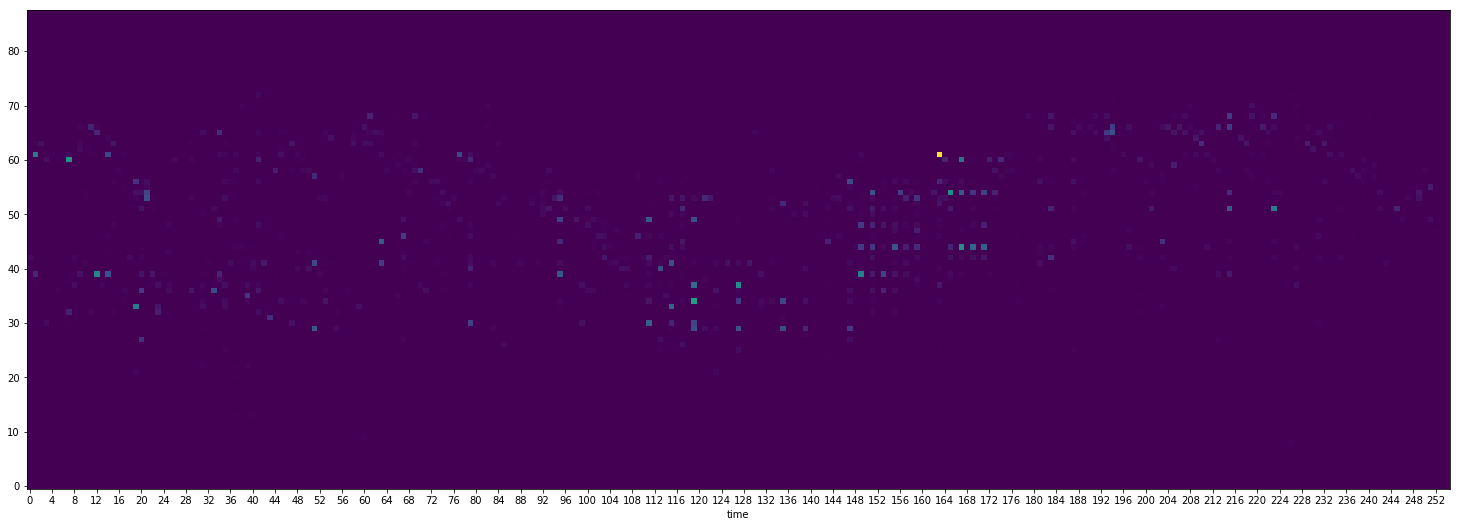

0.0108294  mean for last:  0.0106384


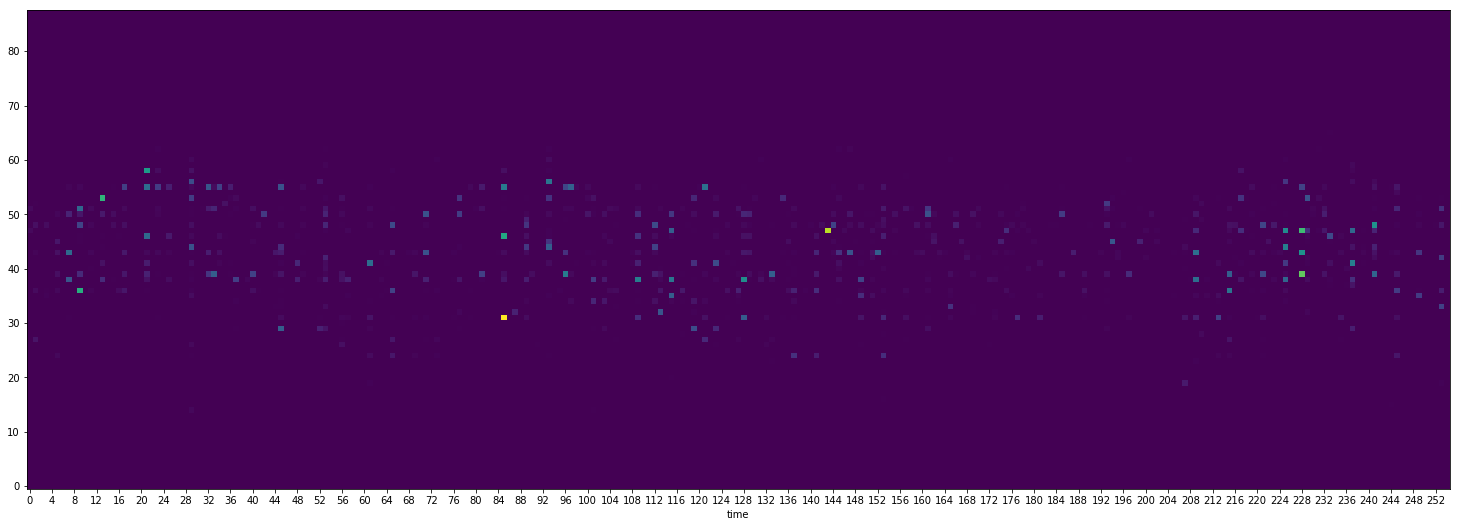

0.0114416  mean for last:  0.0109657


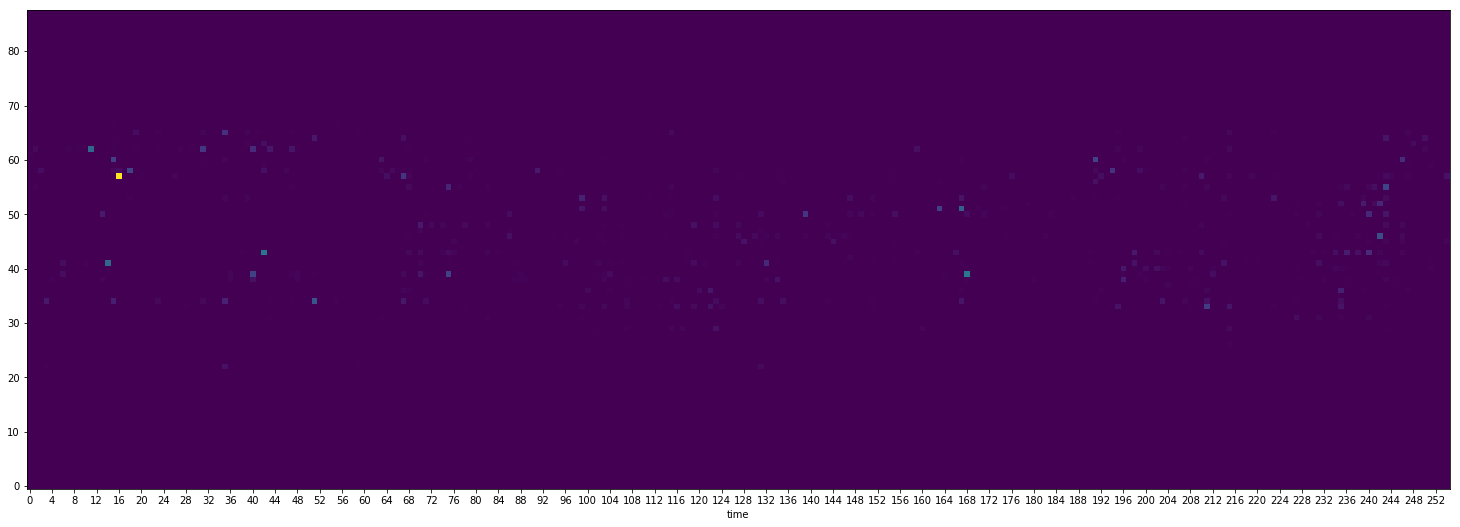

0.00988241  mean for last:  0.0106619


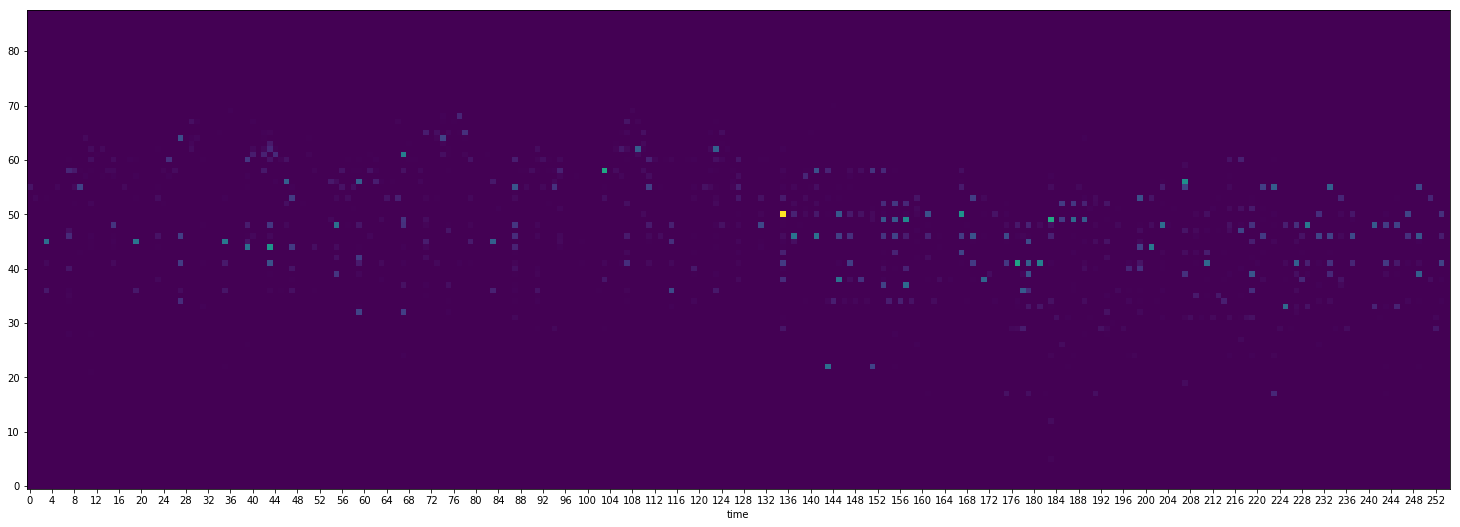

0.00986588  mean for last:  0.00967328


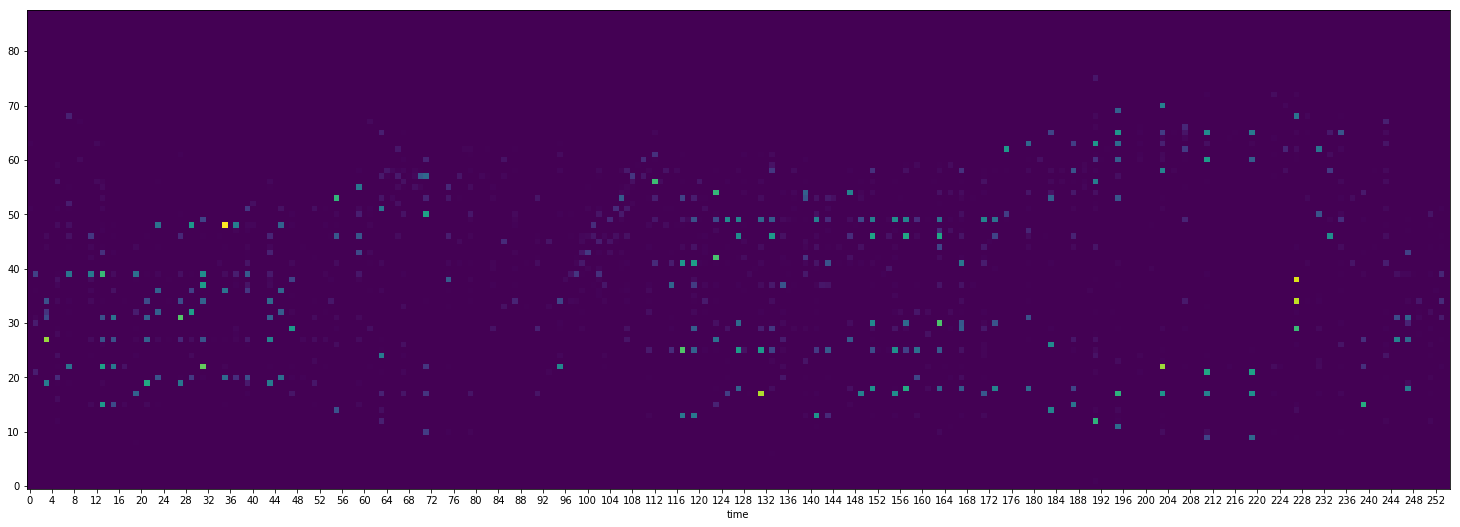

0.00947056  mean for last:  0.00975056


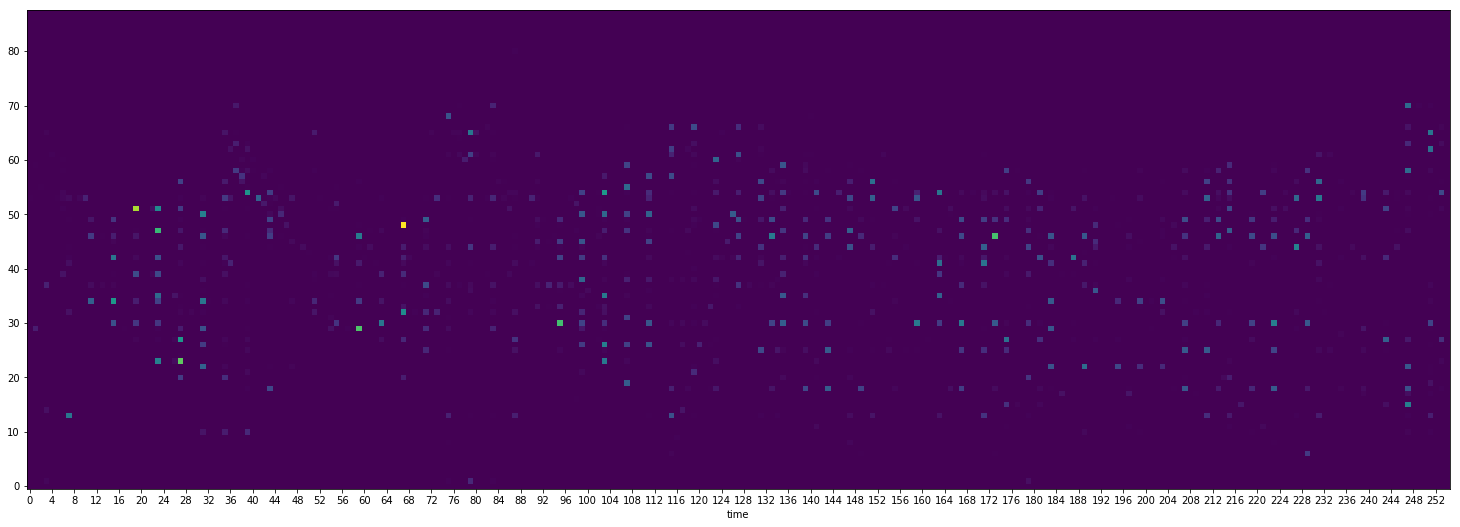

0.00951274  mean for last:  0.00966403


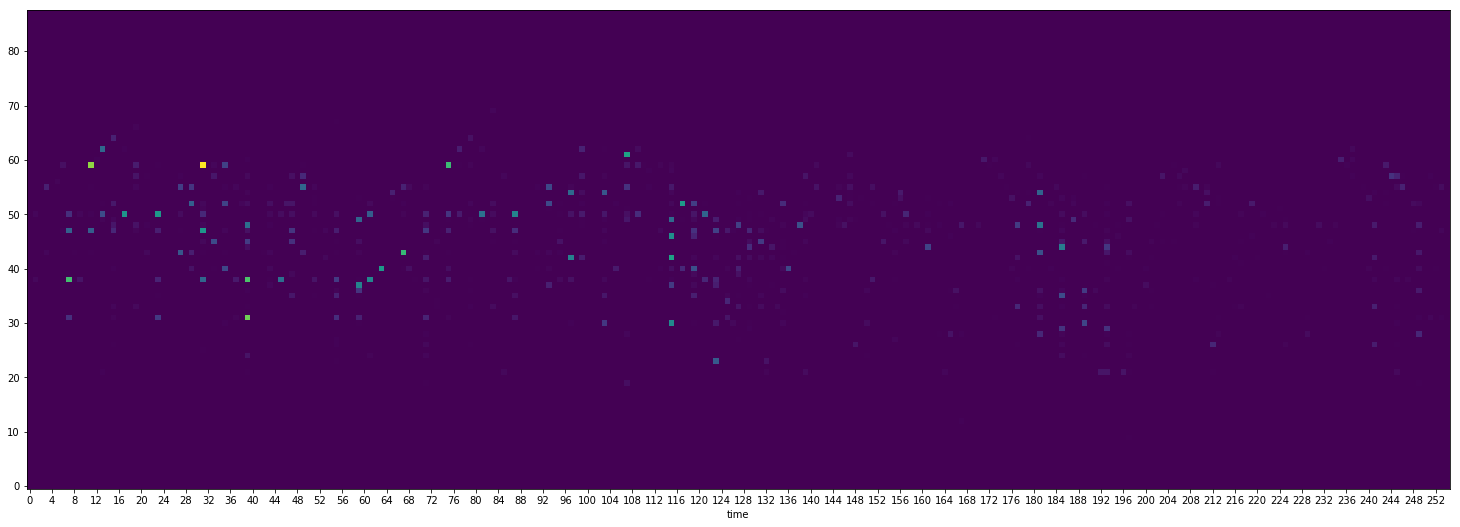

0.00857122  mean for last:  0.00932174


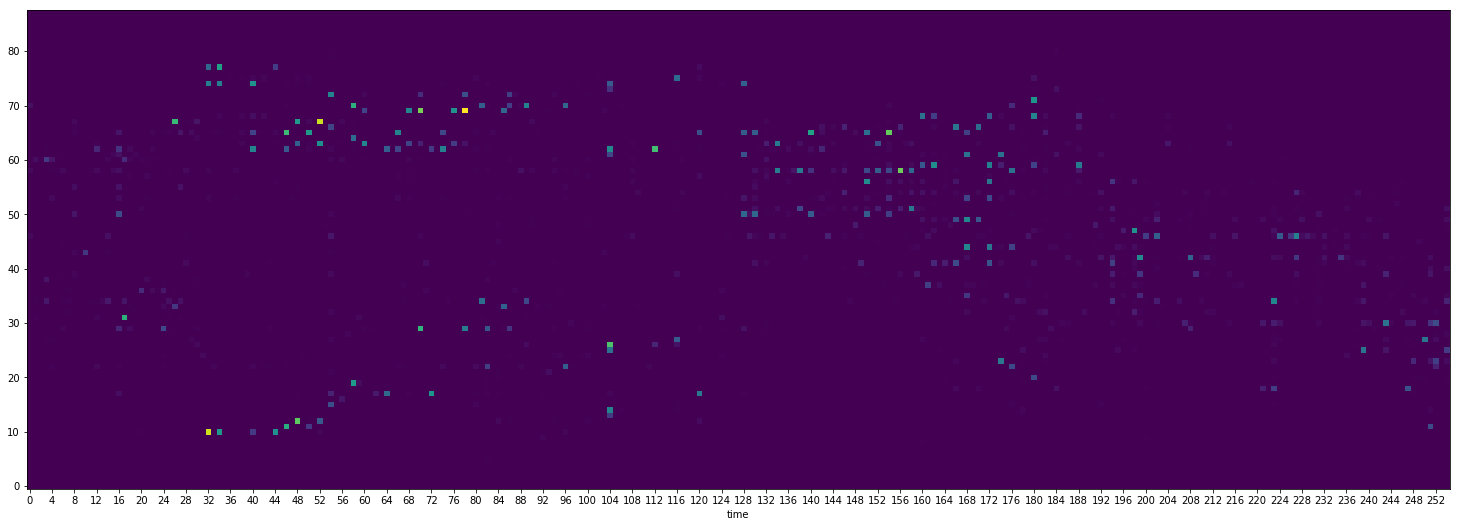

0.00945422  mean for last:  0.00892443


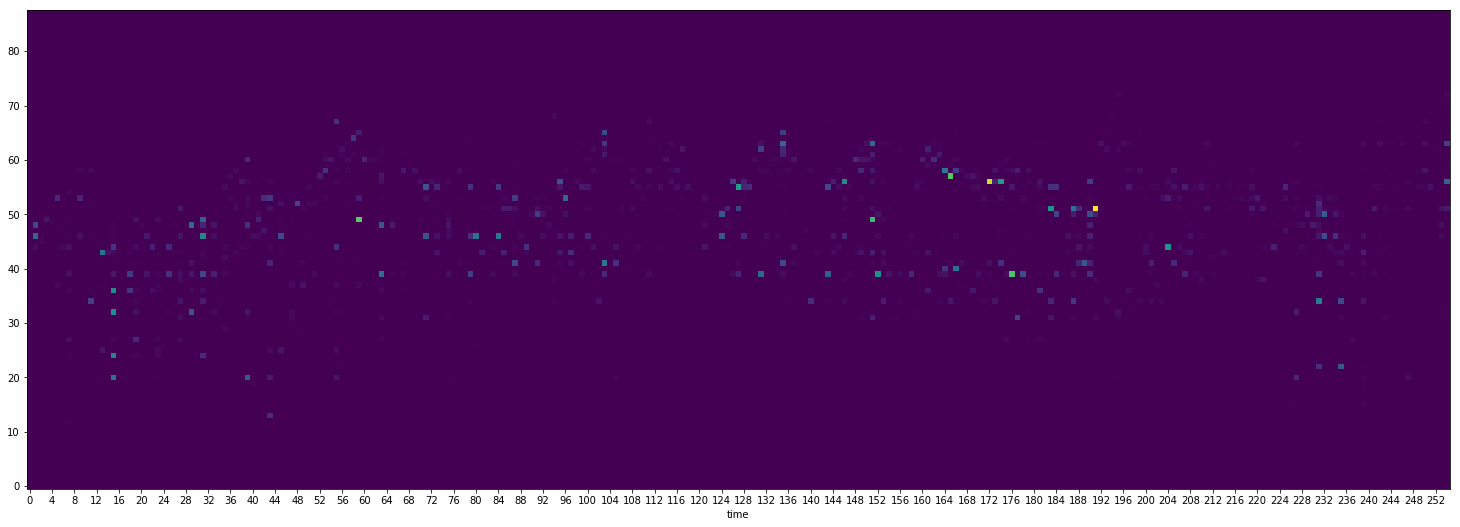

0.00952126  mean for last:  0.00905549


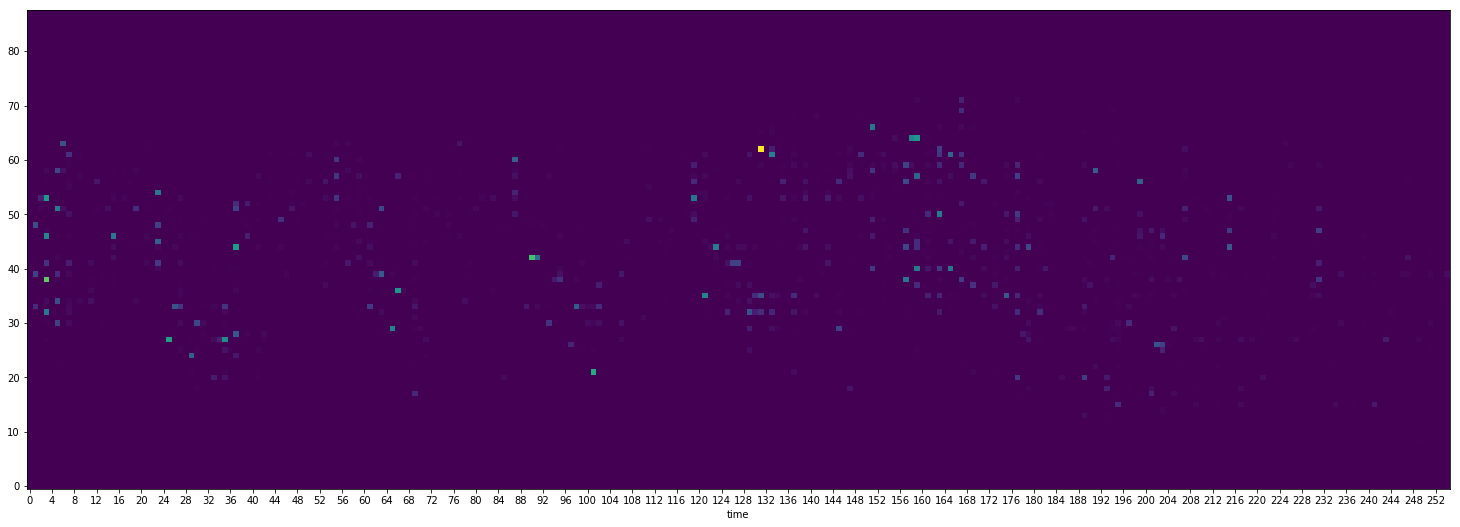

0.00884917  mean for last:  0.00863193


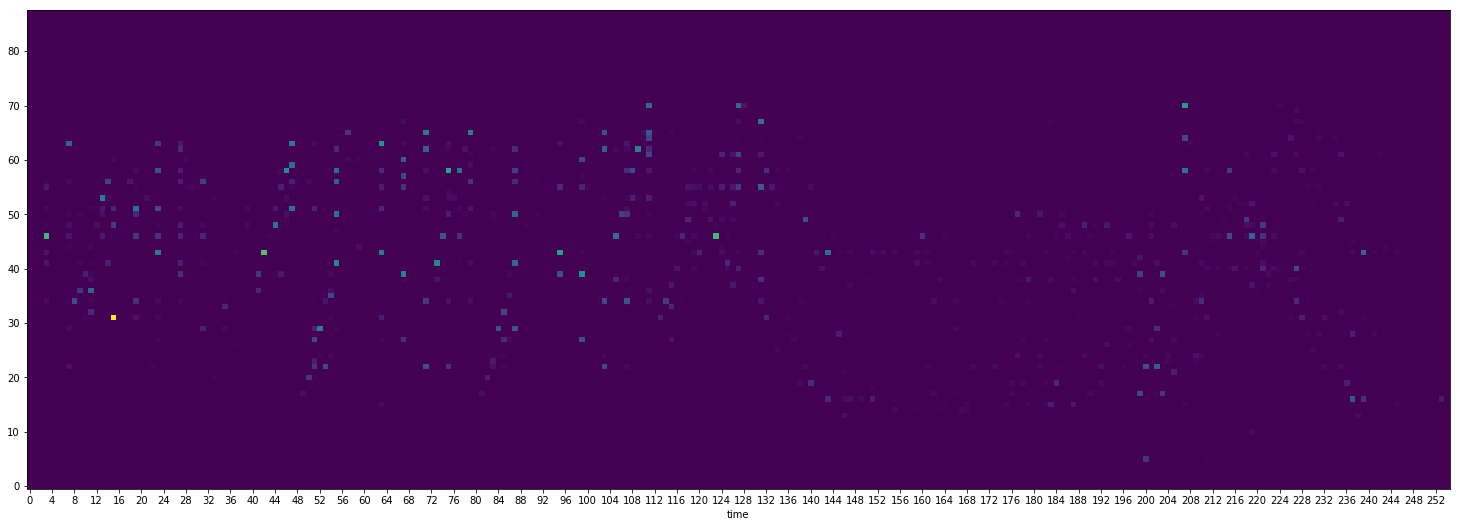

0.0091833  mean for last:  0.00866892


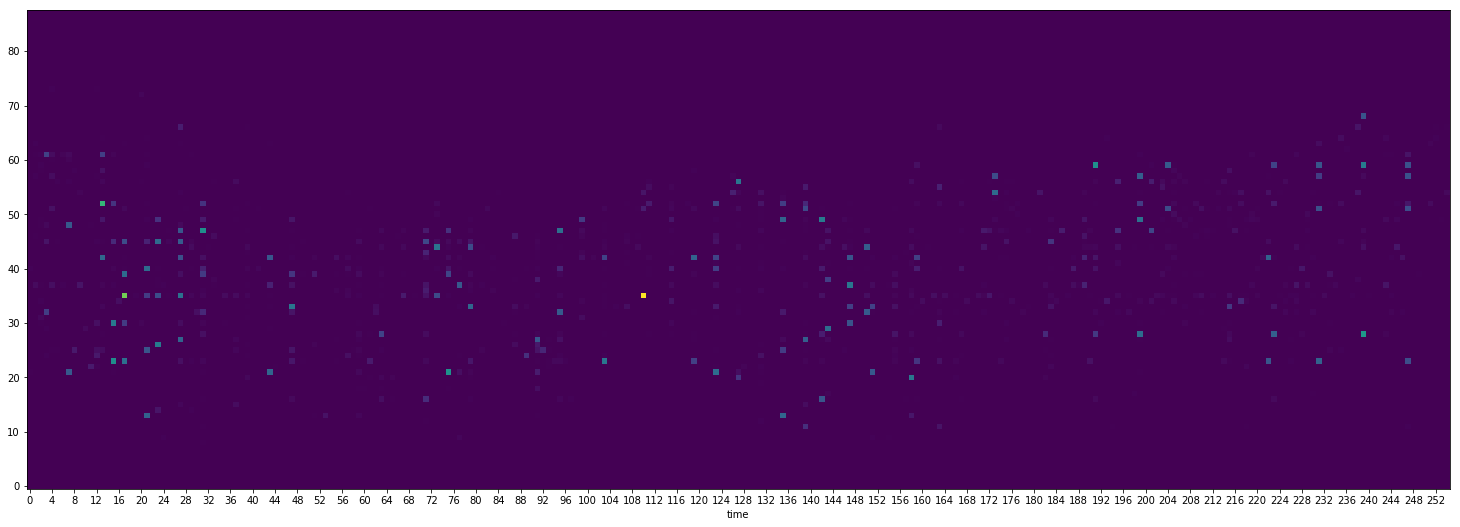

0.00866727  mean for last:  0.00838308


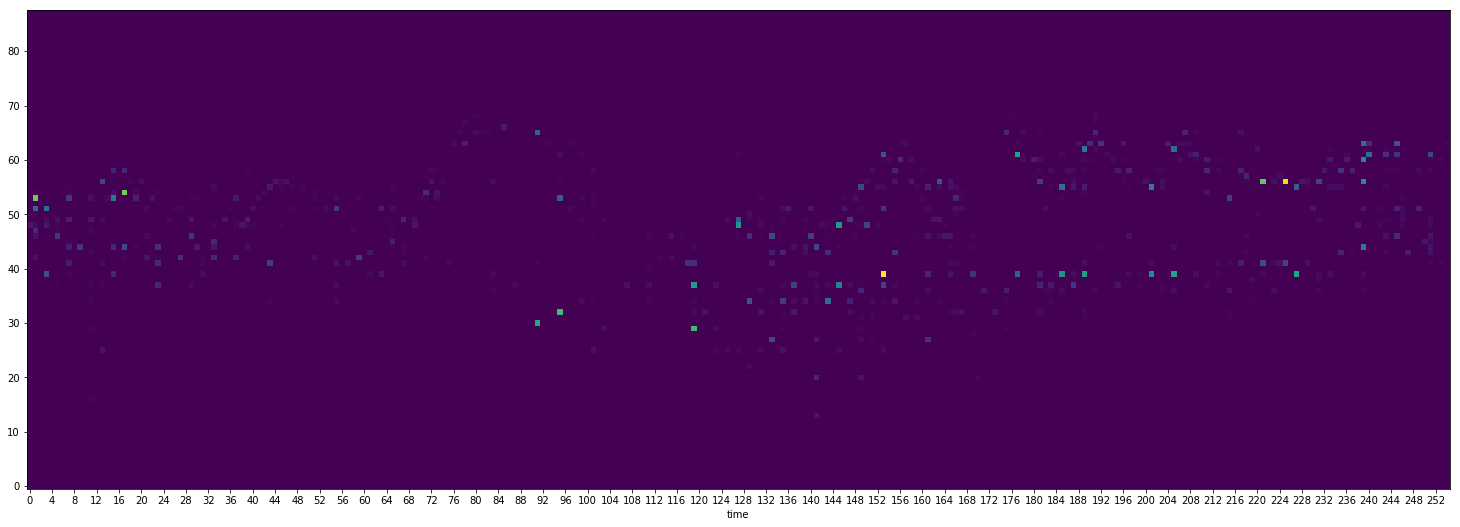

0.00821413  mean for last:  0.00816545


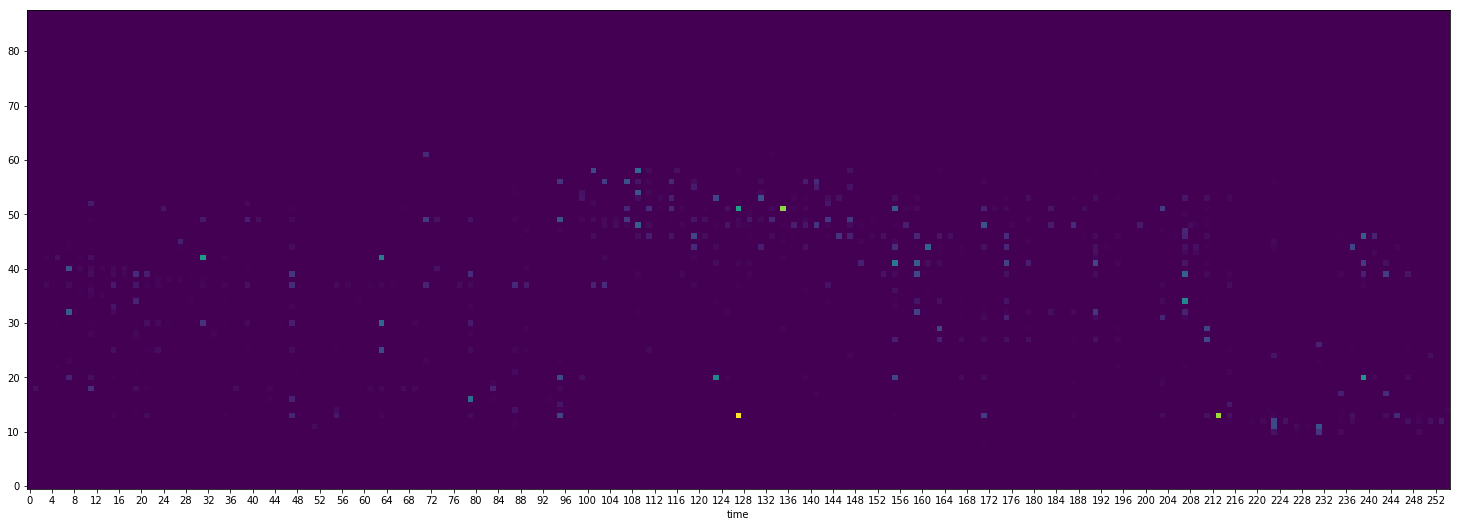

0.00761544  mean for last:  0.00791307


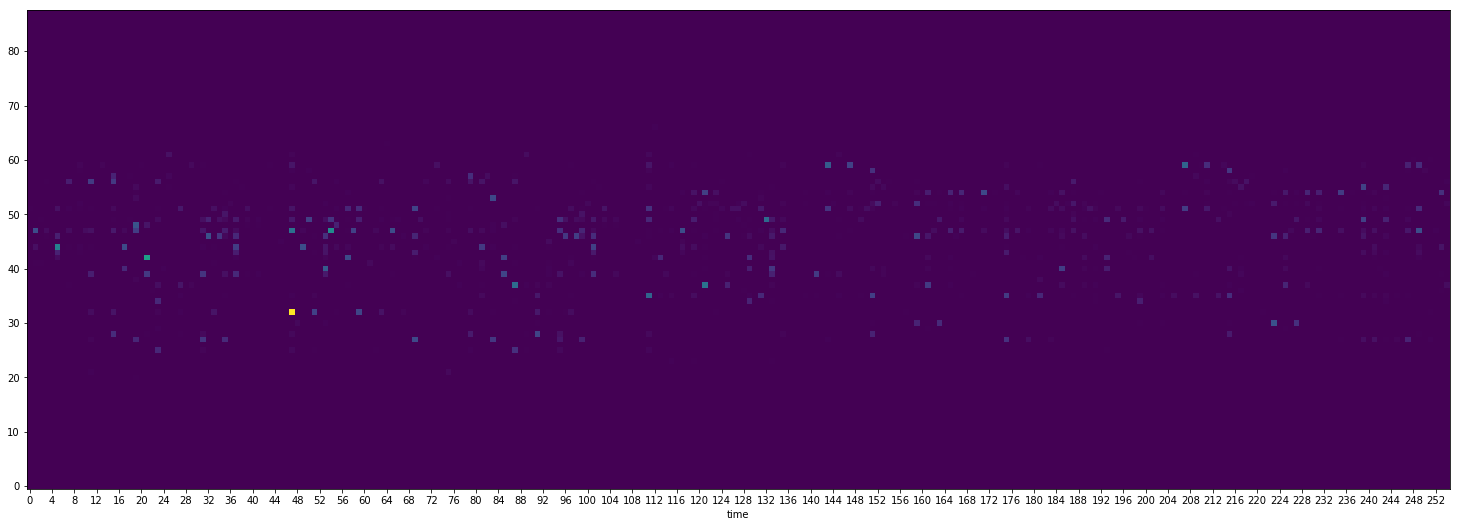

0.00817395  mean for last:  0.00811647


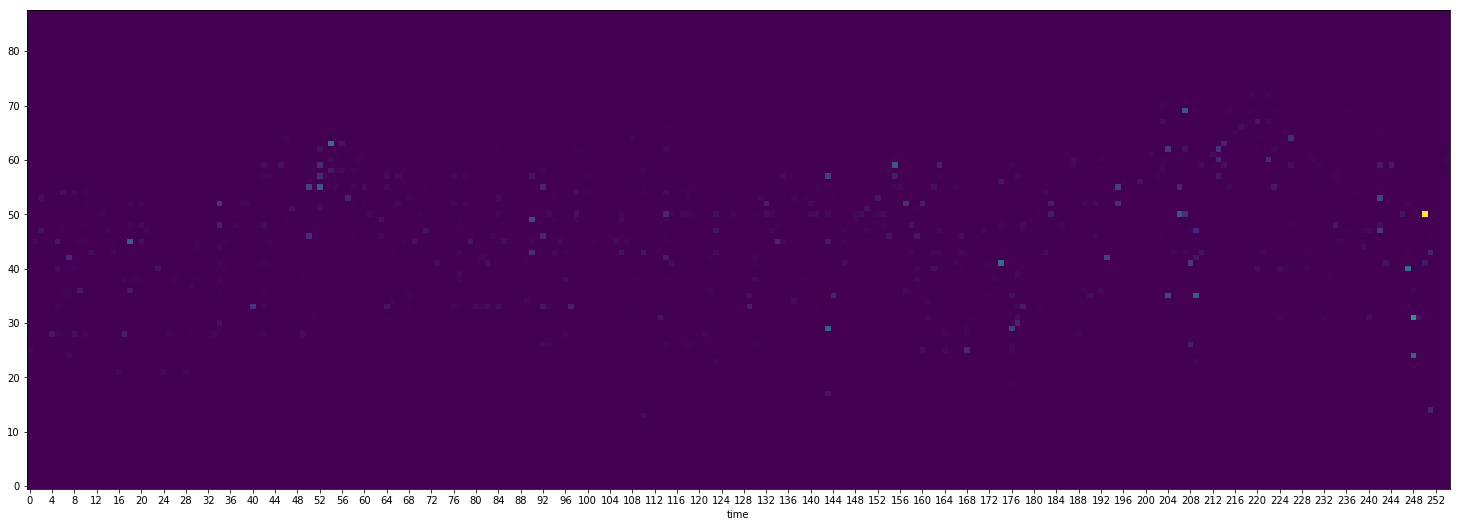

0.00810158  mean for last:  0.00775219


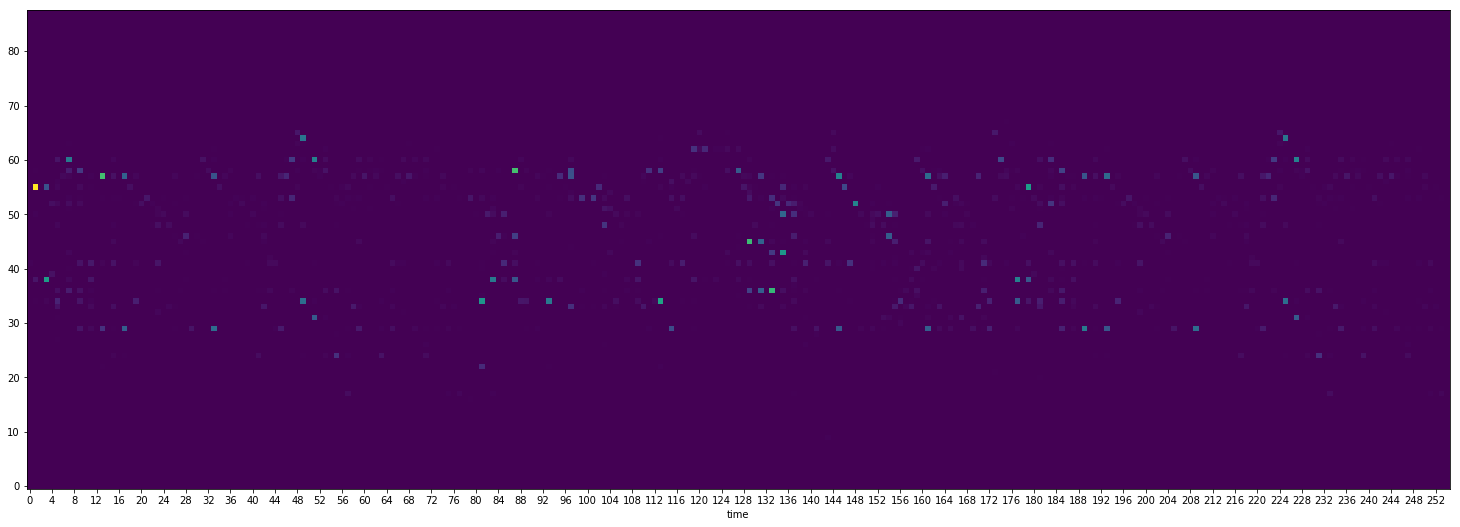

0.00719795  mean for last:  0.00765258


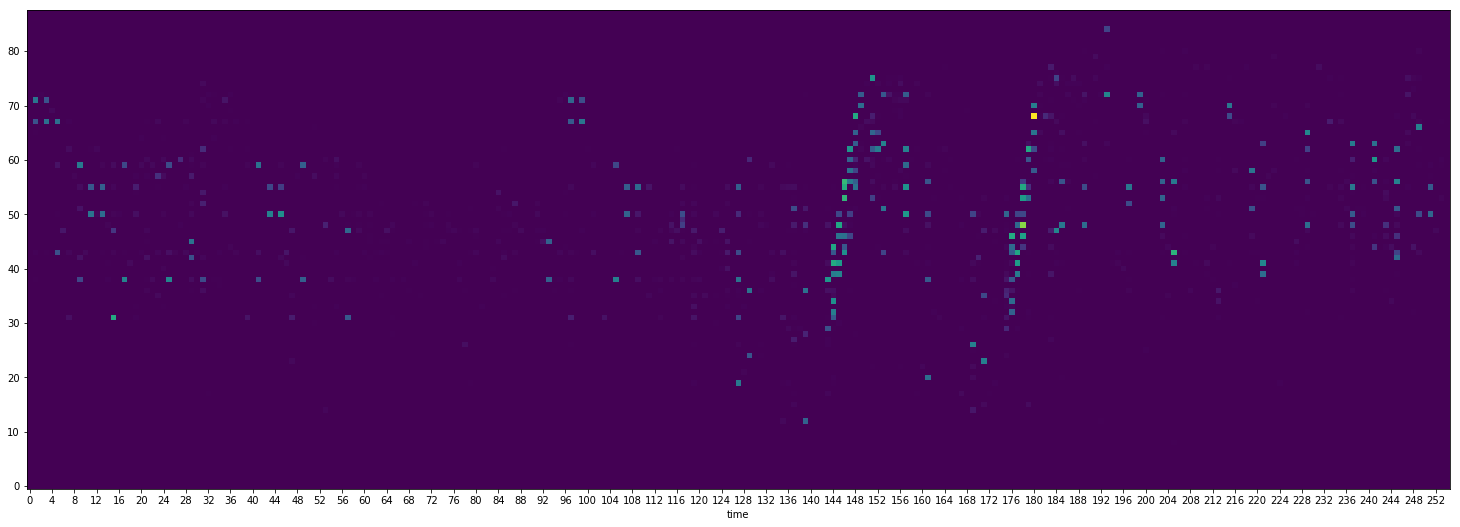

0.0082627  mean for last:  0.00842626


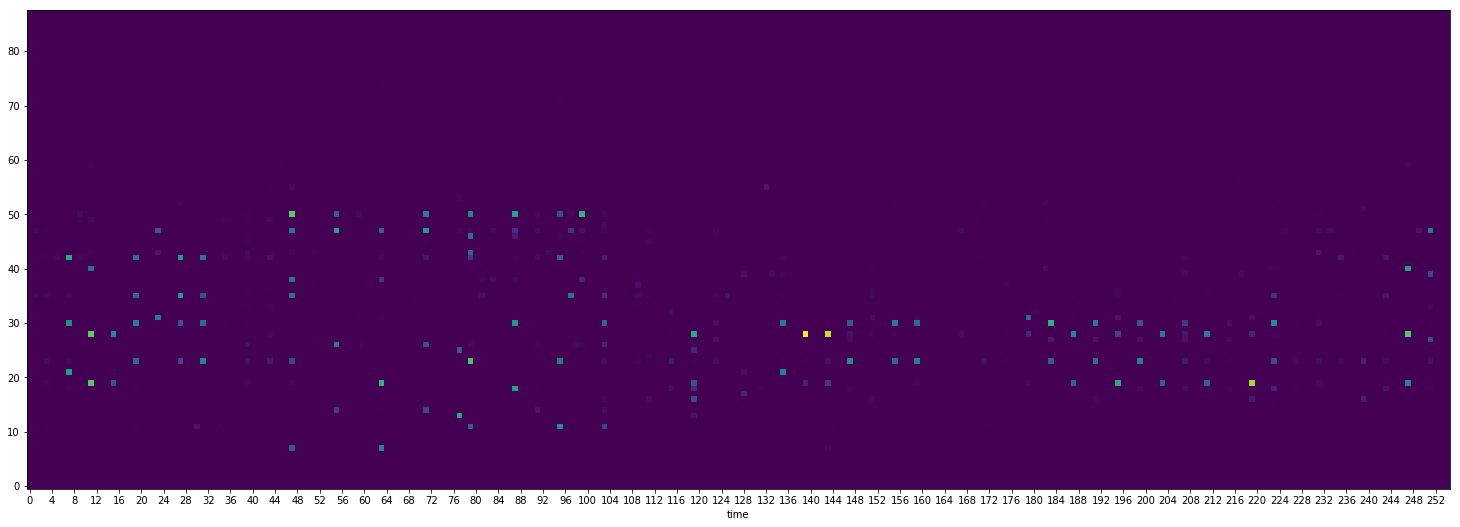

0.00789513  mean for last:  0.0078601


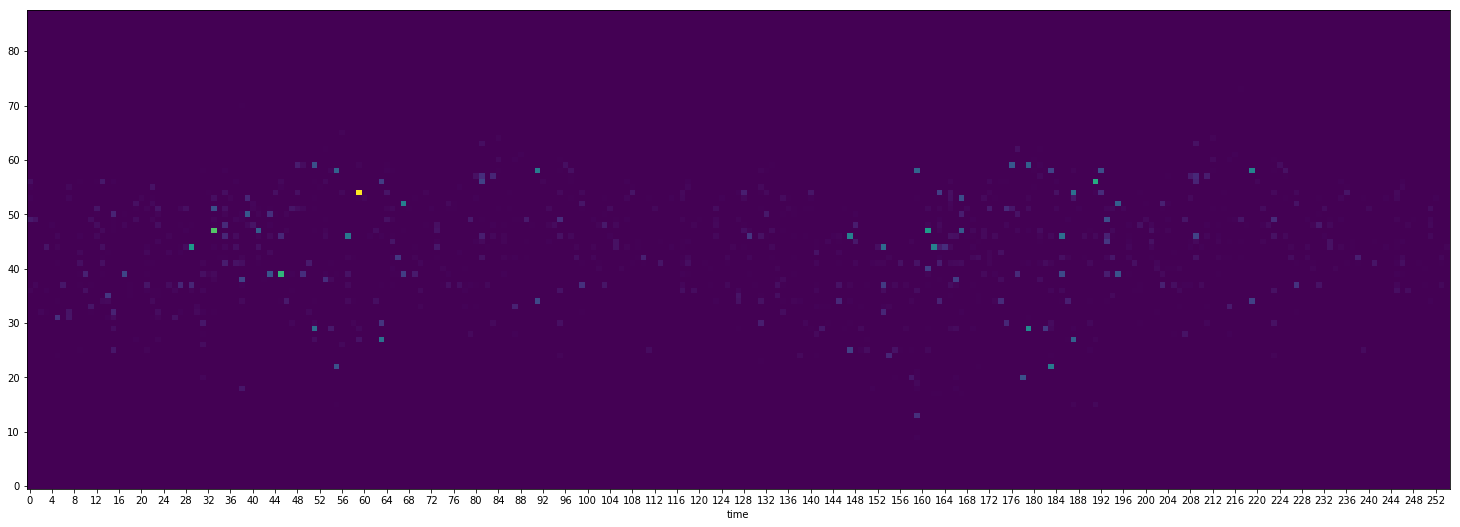

0.00765269  mean for last:  0.00703724


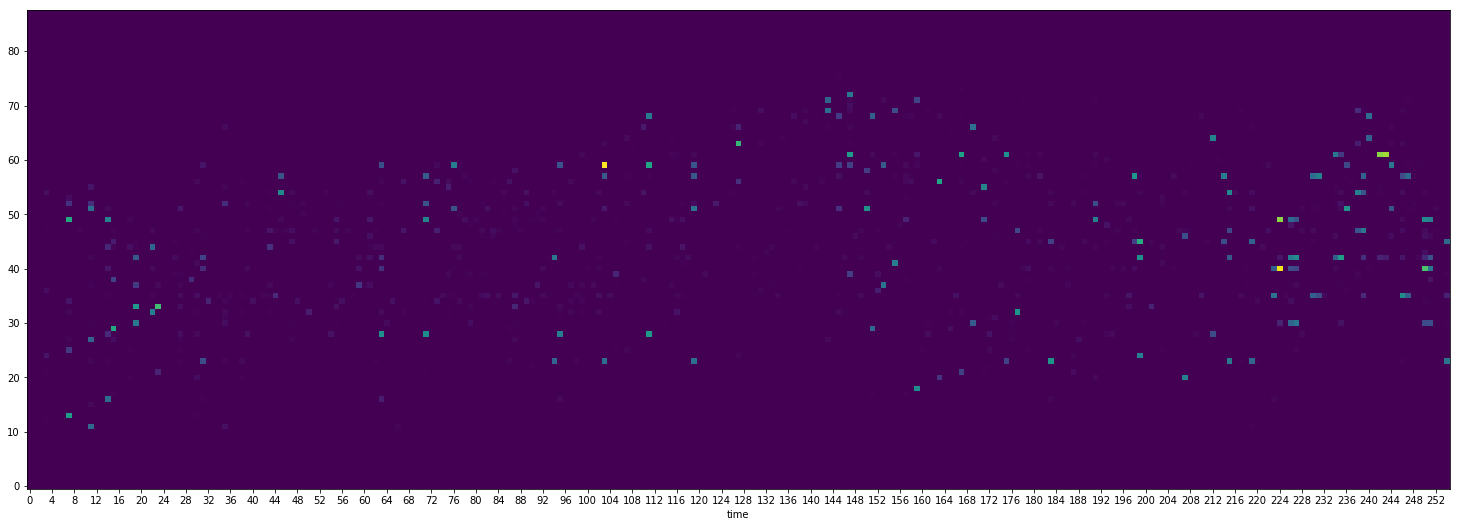

0.0072024  mean for last:  0.00702946


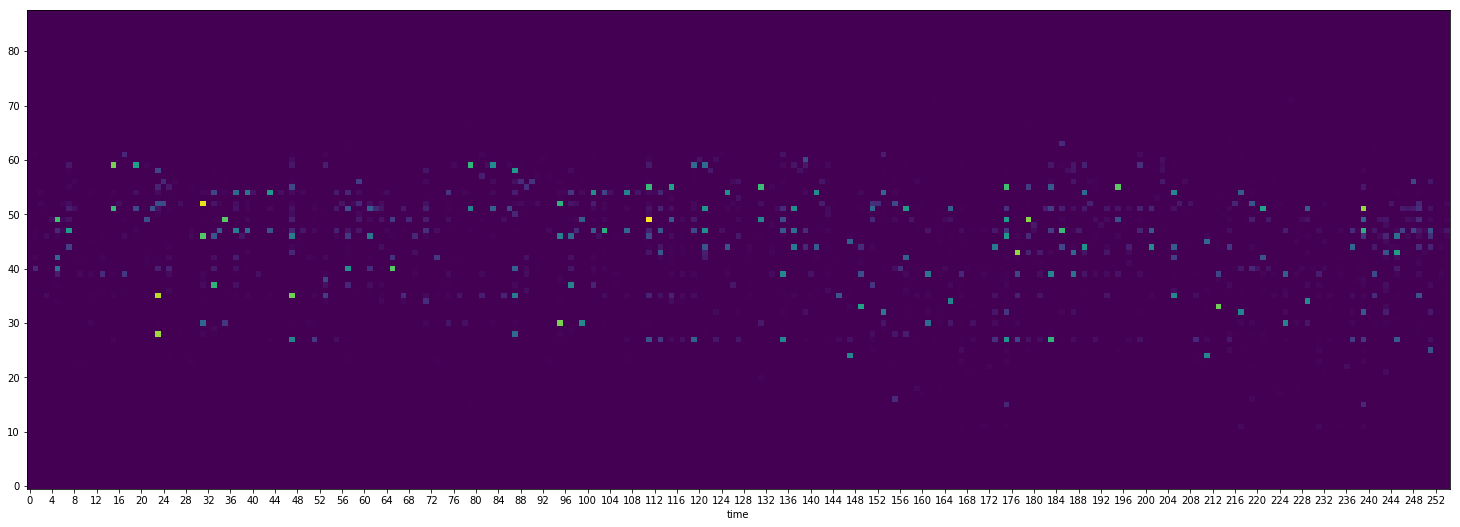

0.00730176  mean for last:  0.0073078


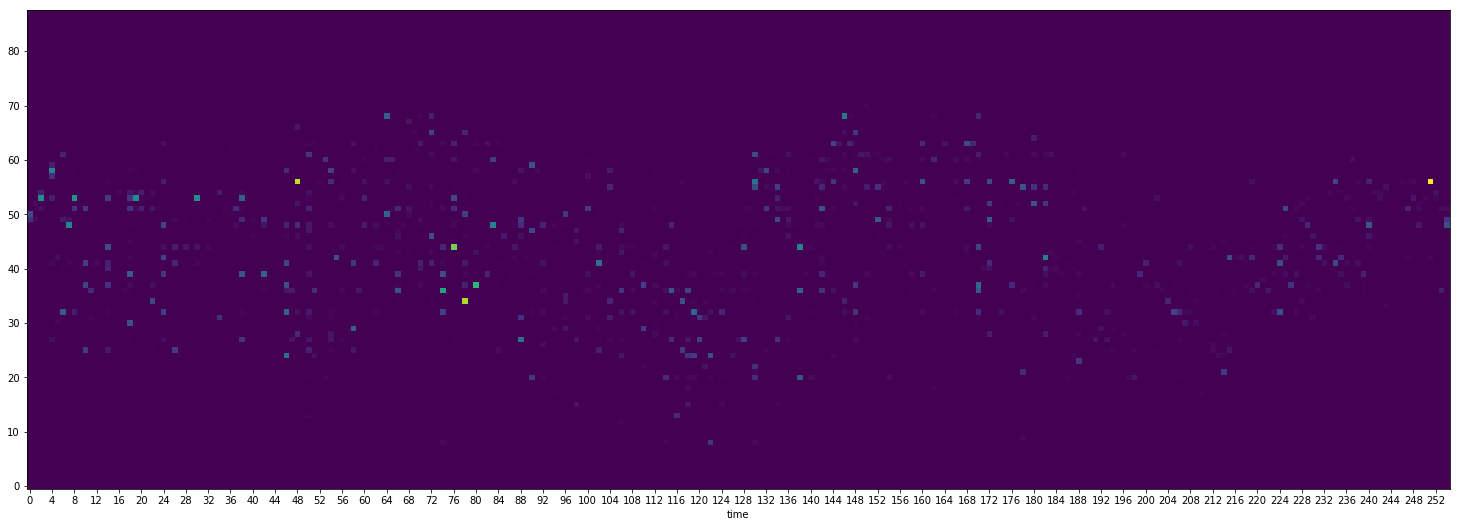

0.00664274  mean for last:  0.00681896


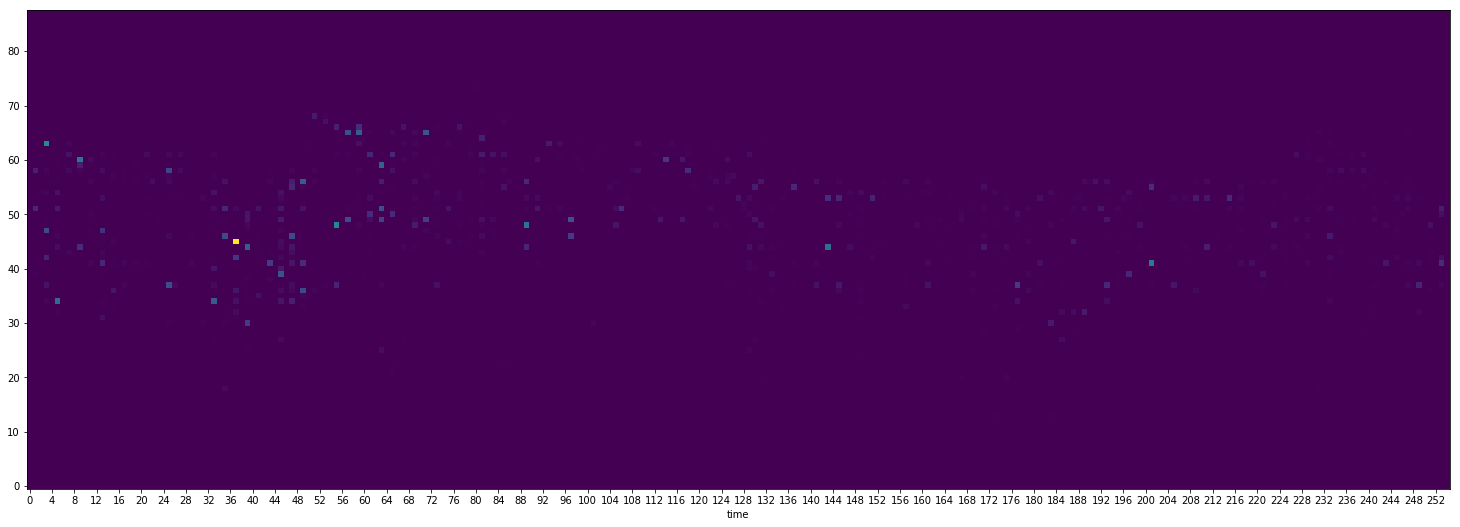

0.00648281  mean for last:  0.00663732


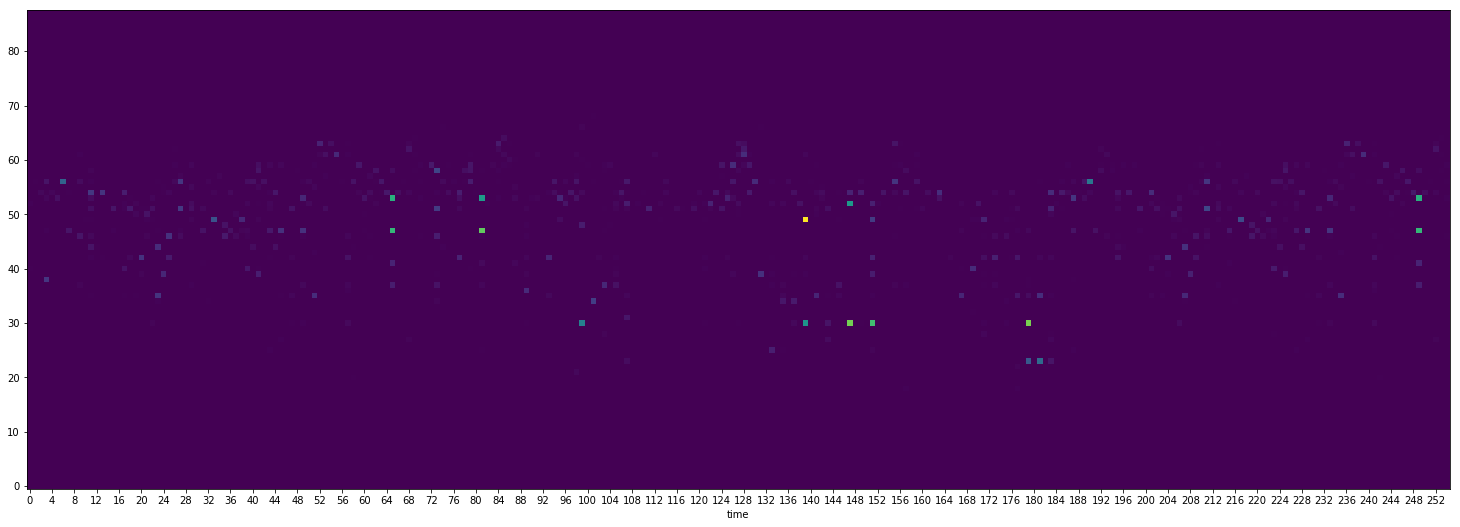

0.0064373  mean for last:  0.00682109


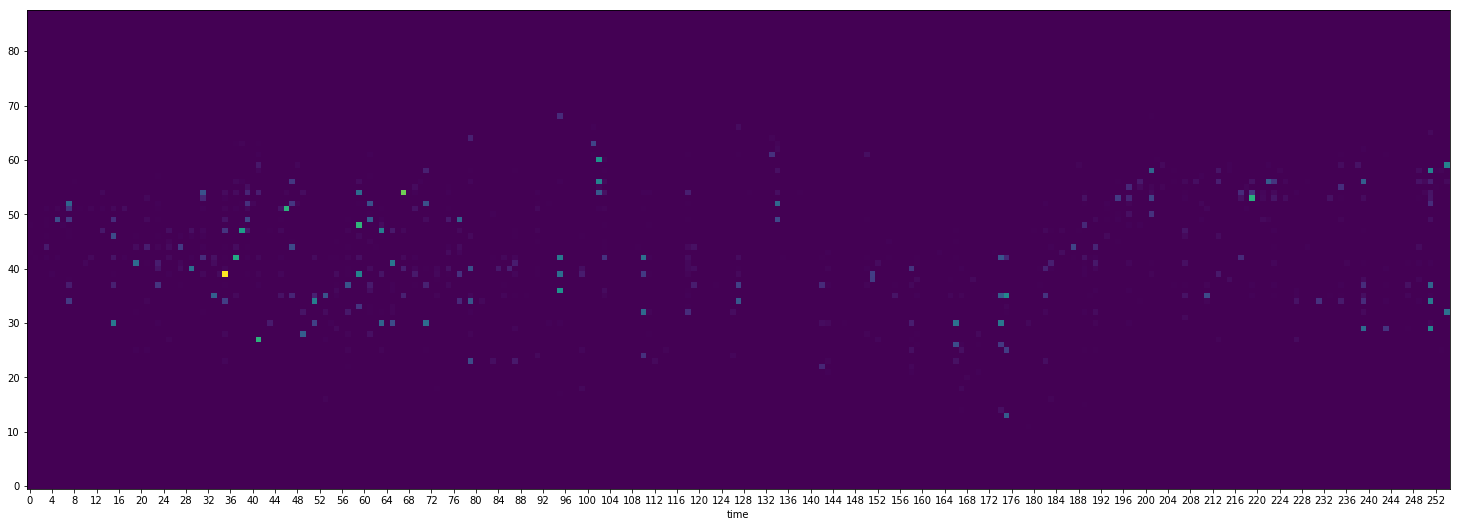

0.00704098  mean for last:  0.00653687


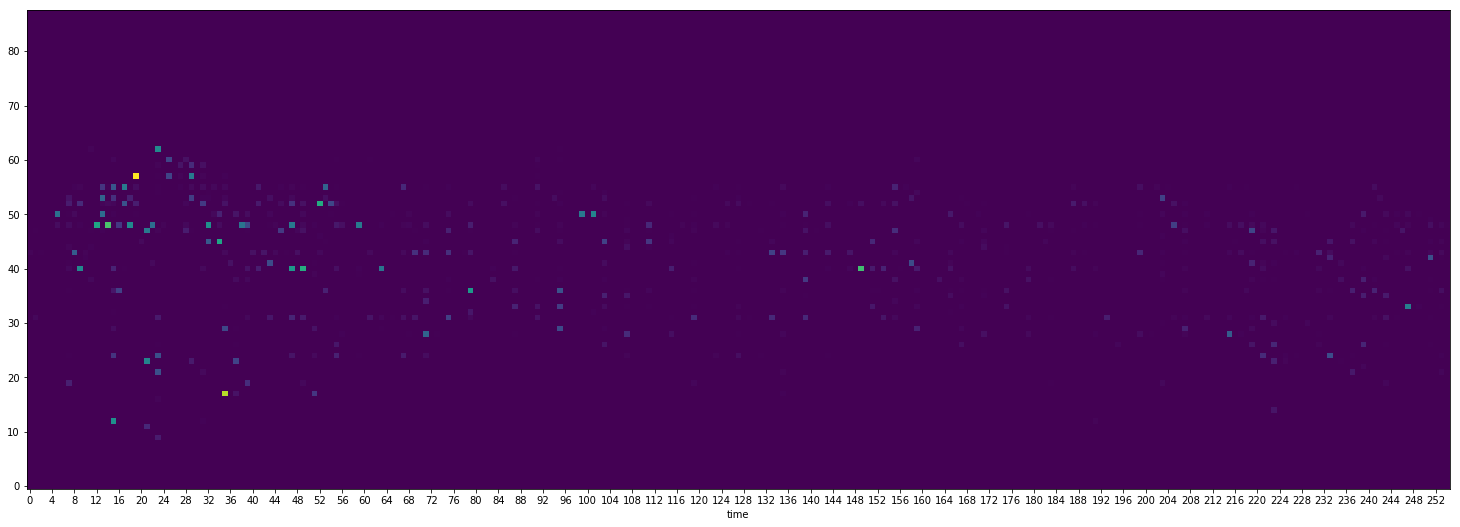

0.00690915  mean for last:  0.00657714


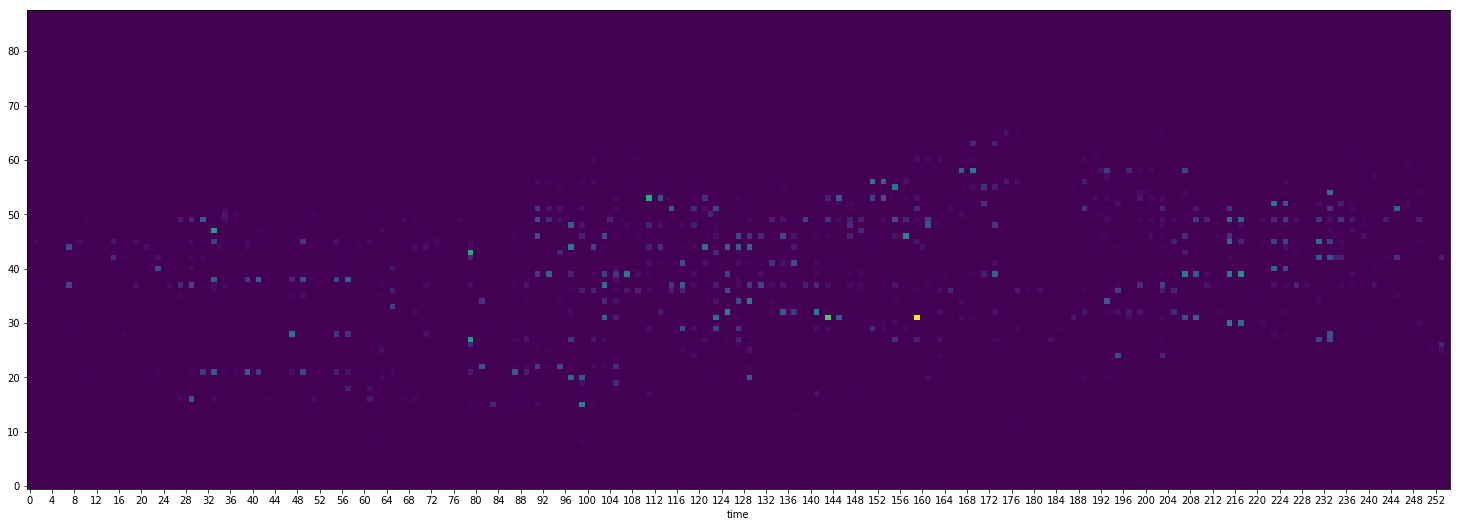

0.00677401  mean for last:  0.00650464


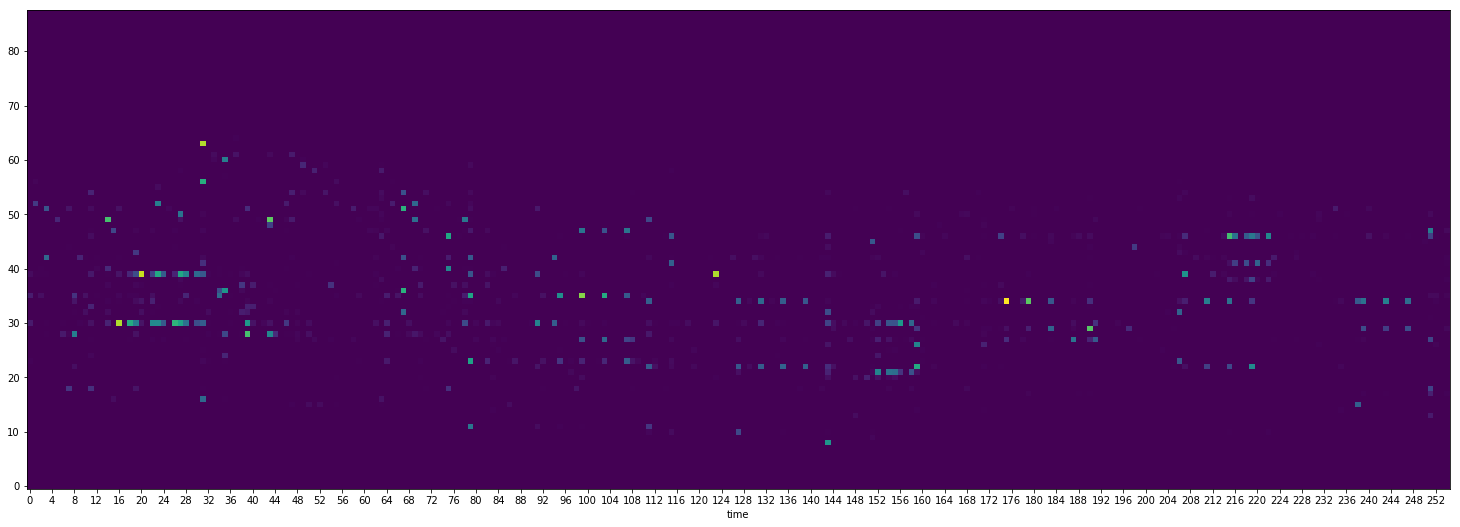

0.00605236  mean for last:  0.00648278


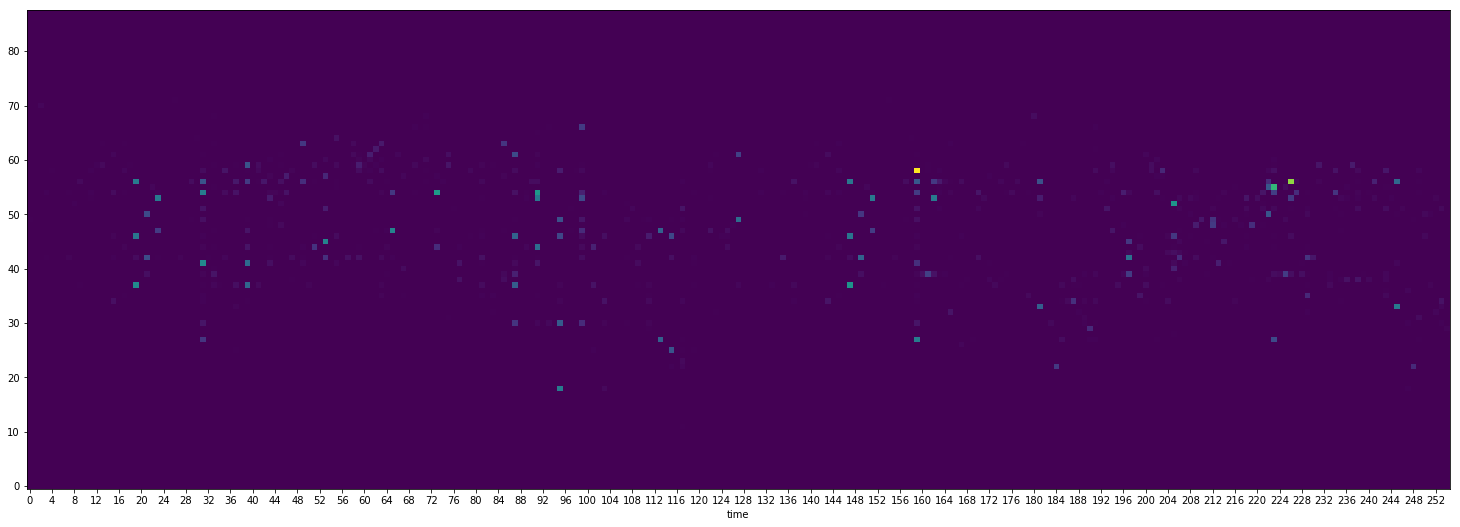

0.00639088  mean for last:  0.00636465


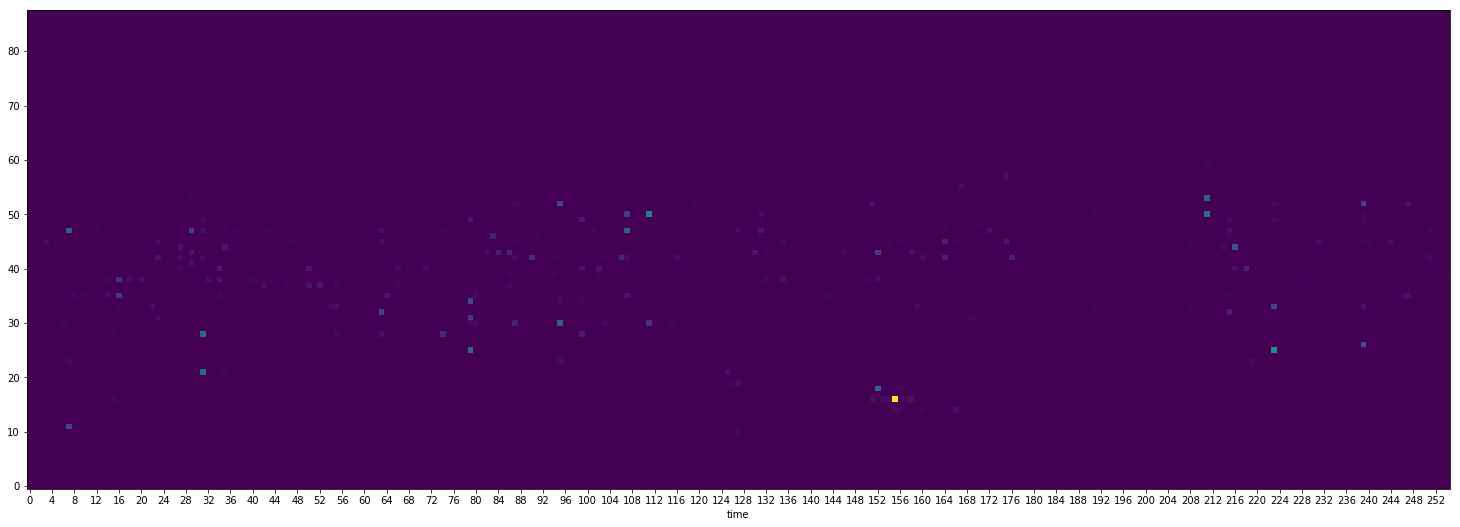

0.00587952  mean for last:  0.00613253


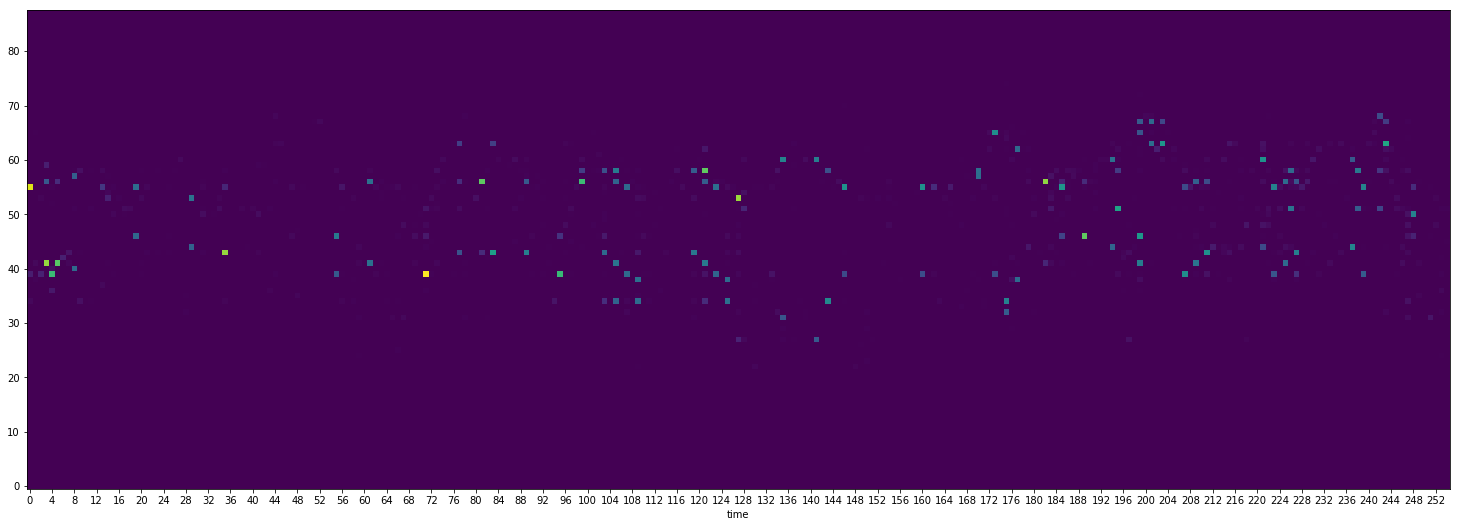

0.00725  mean for last:  0.00647676


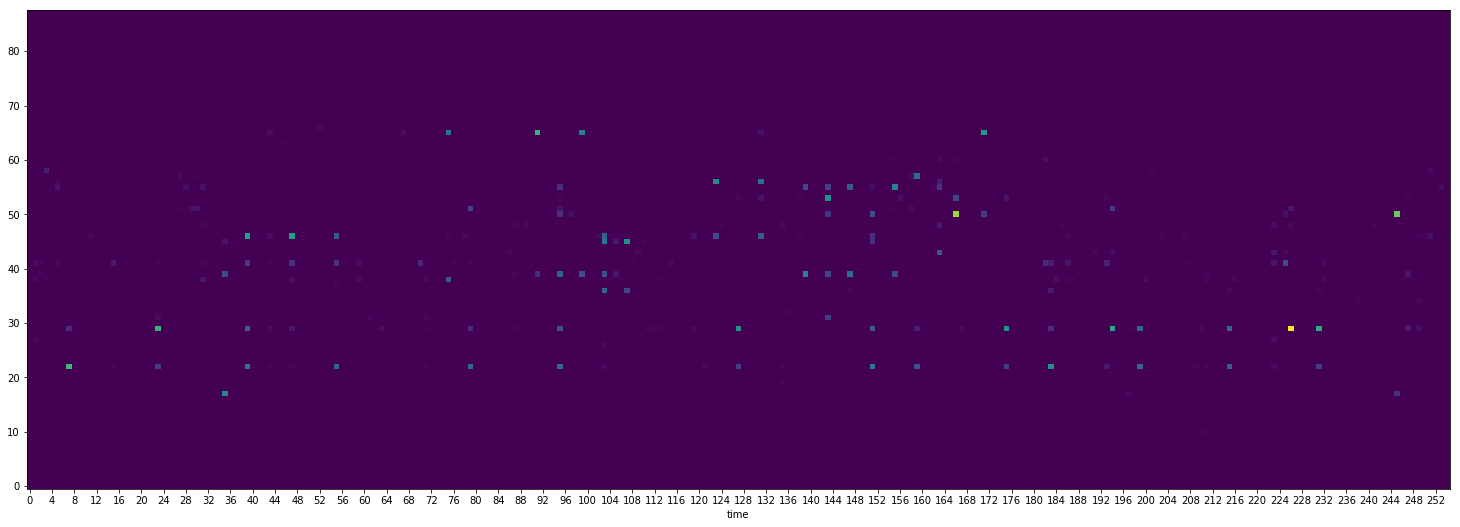

0.00698844  mean for last:  0.00661861


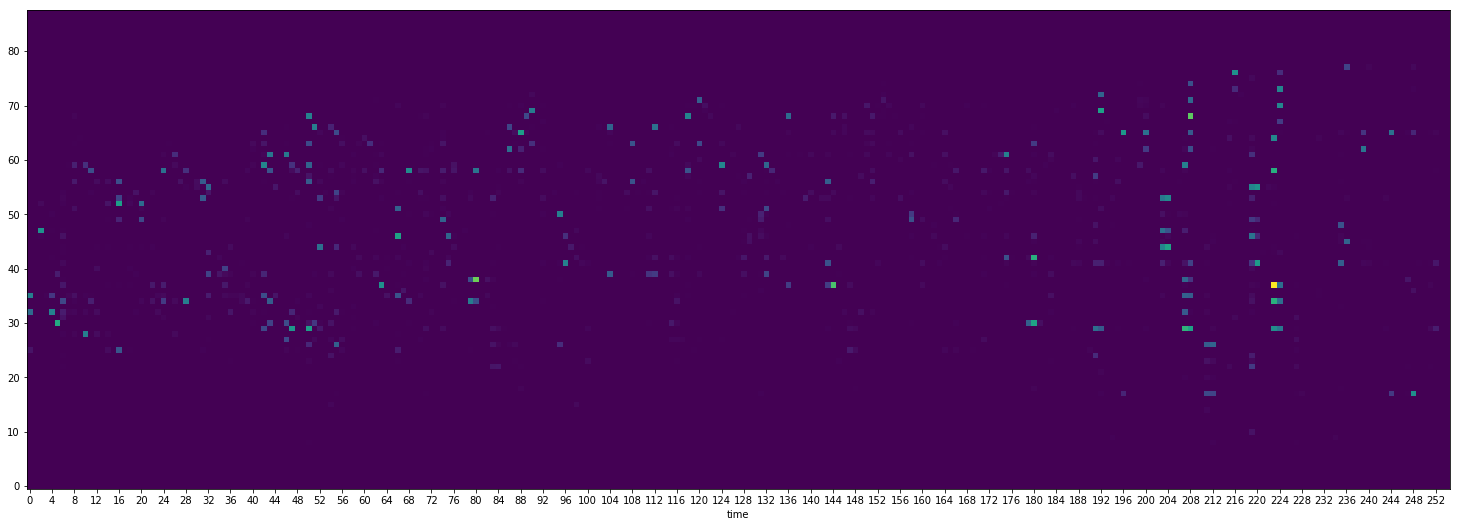

0.00640683  mean for last:  0.00610205


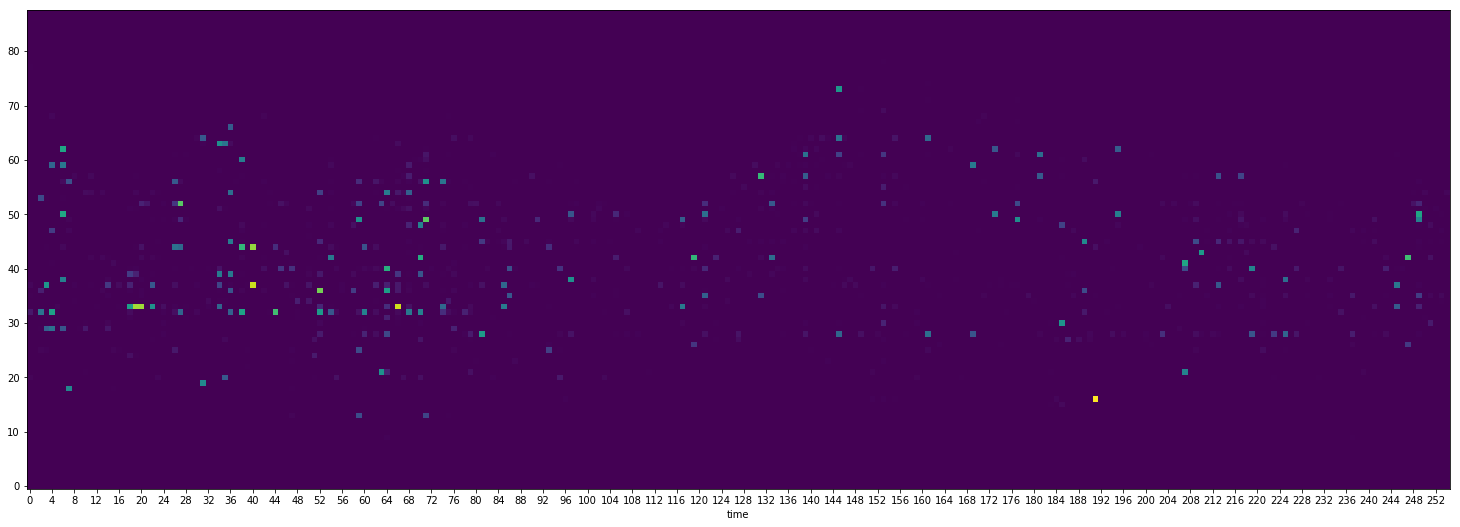

0.00558878  mean for last:  0.00603515


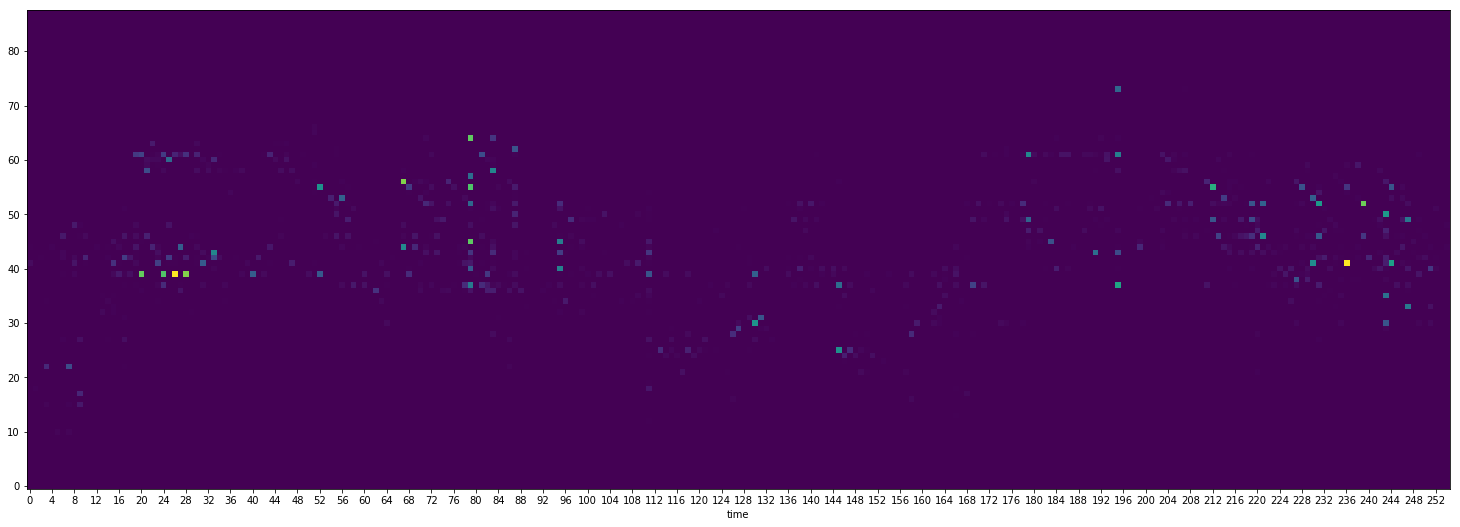

0.00604883  mean for last:  0.00588395


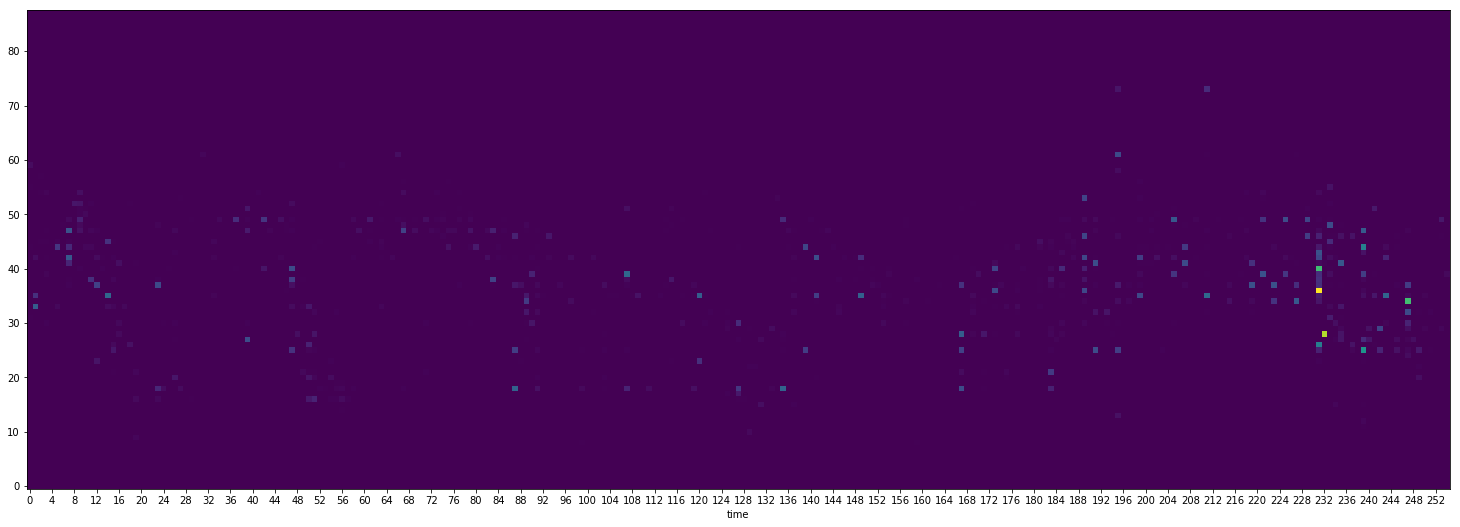

0.00614418  mean for last:  0.00570711


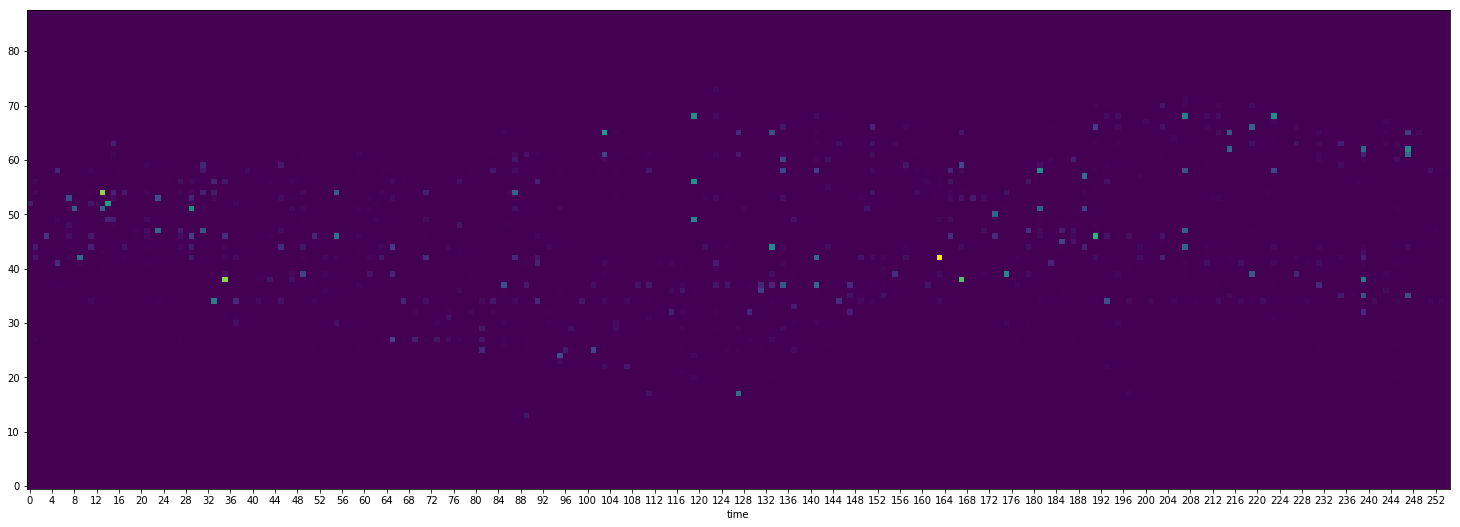

0.00775727  mean for last:  0.00576025


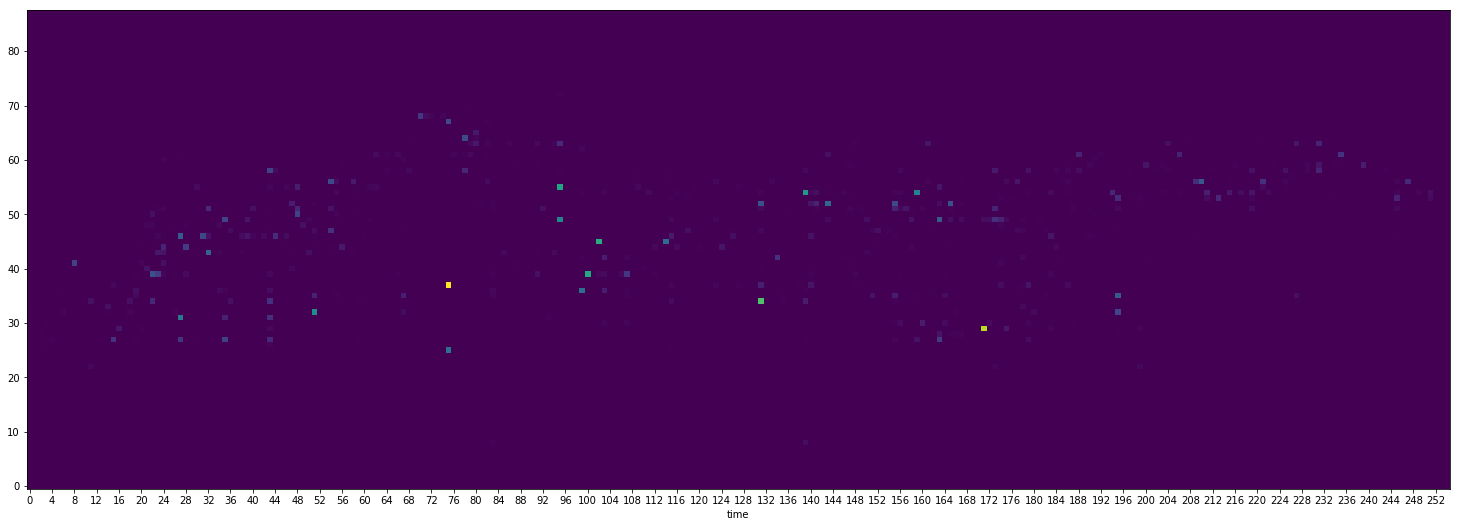

0.00768216  mean for last:  0.0106521


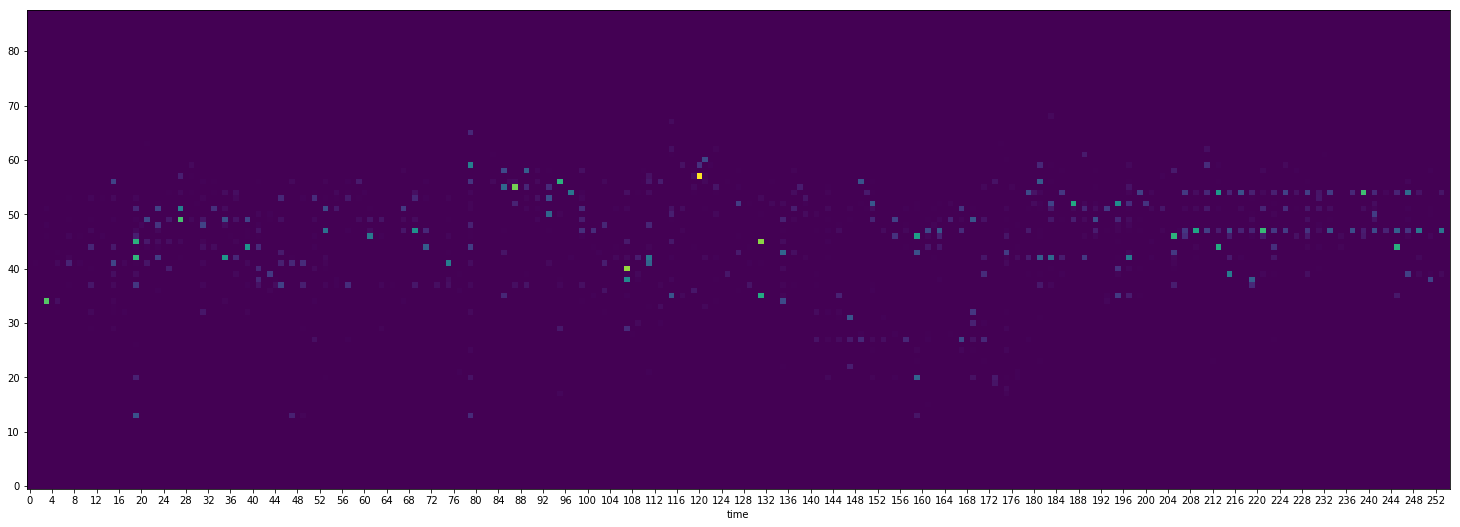

0.00631722  mean for last:  0.0072237


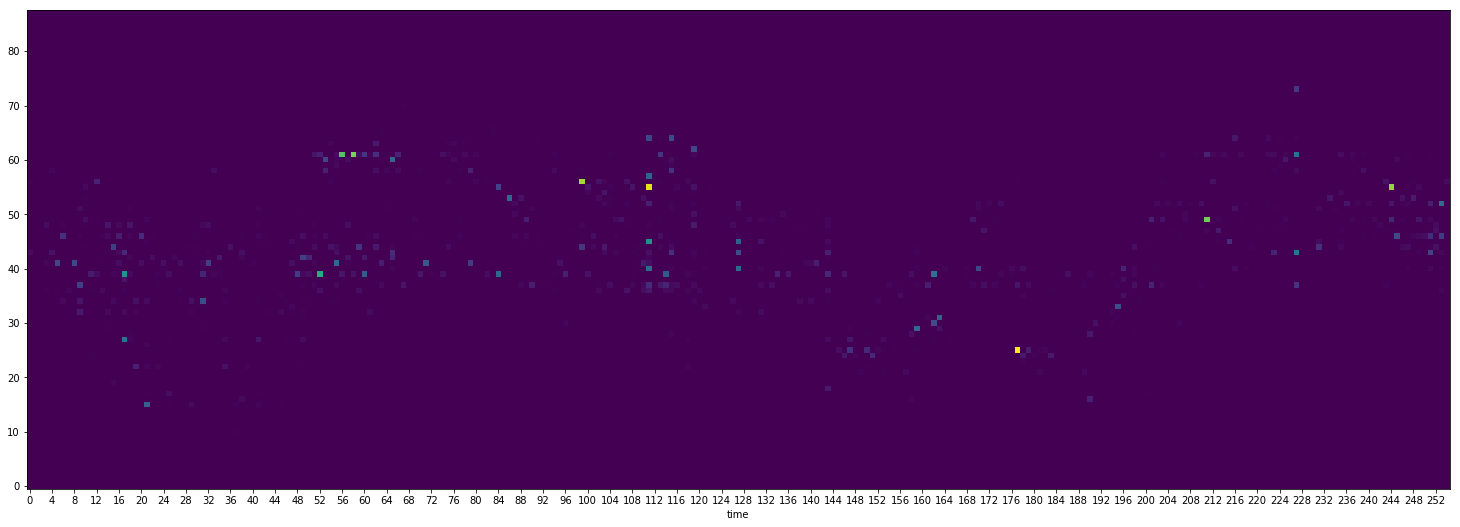

0.00652569  mean for last:  0.0061407


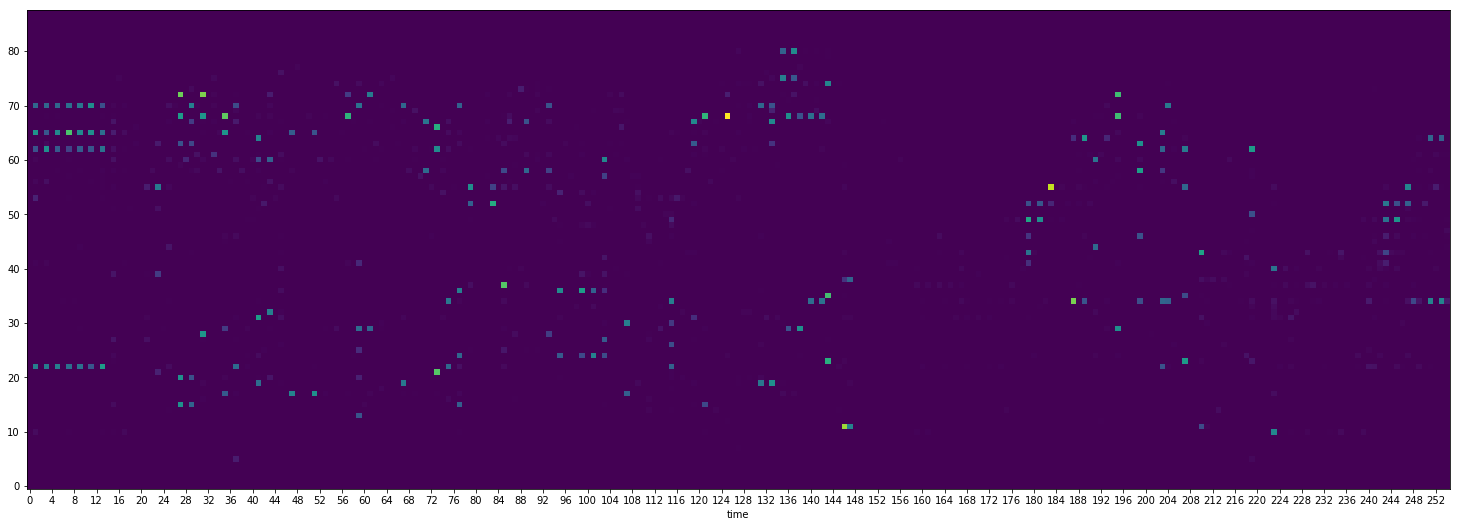

0.00524029  mean for last:  0.0055271


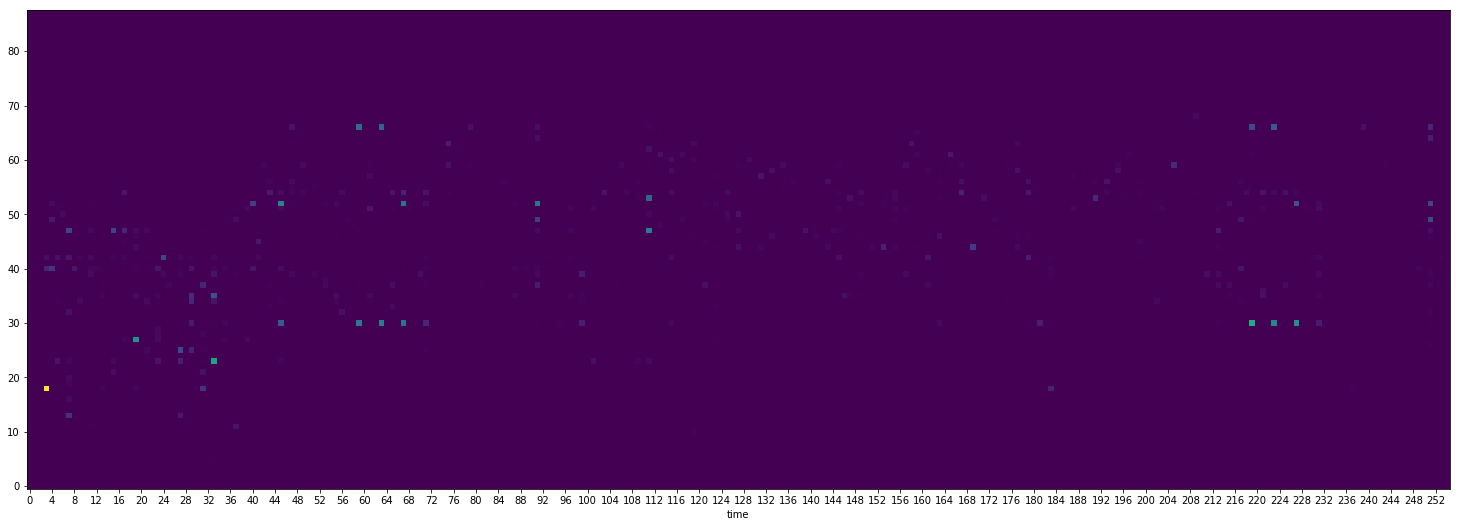

0.00496845  mean for last:  0.00546469


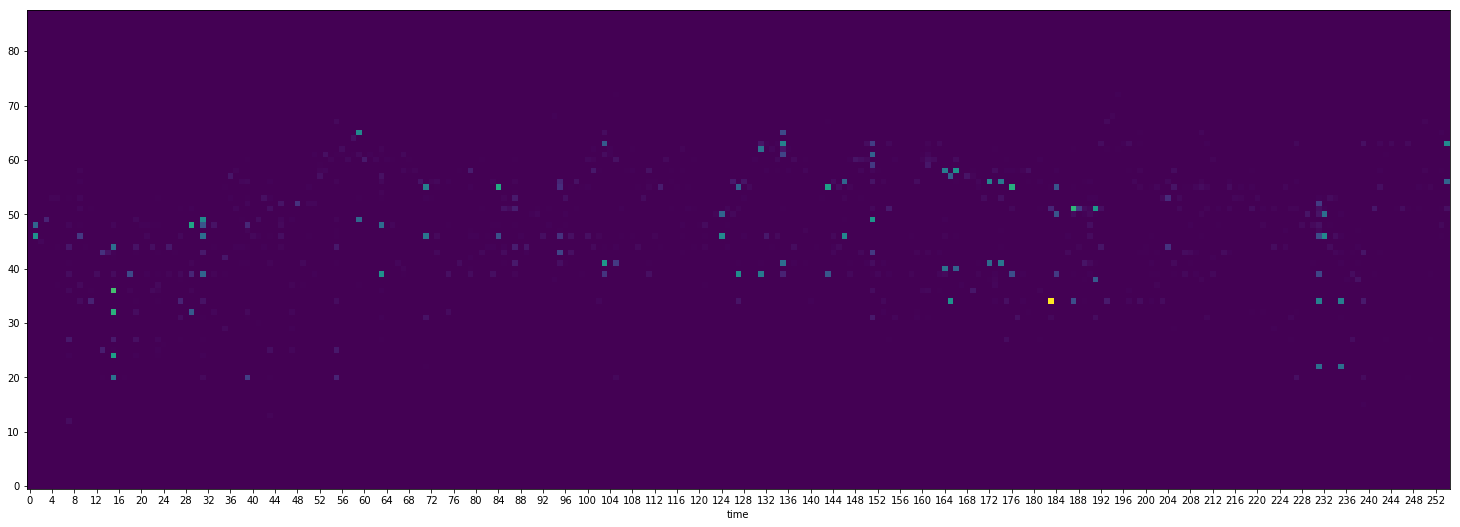

0.00567663  mean for last:  0.00532434


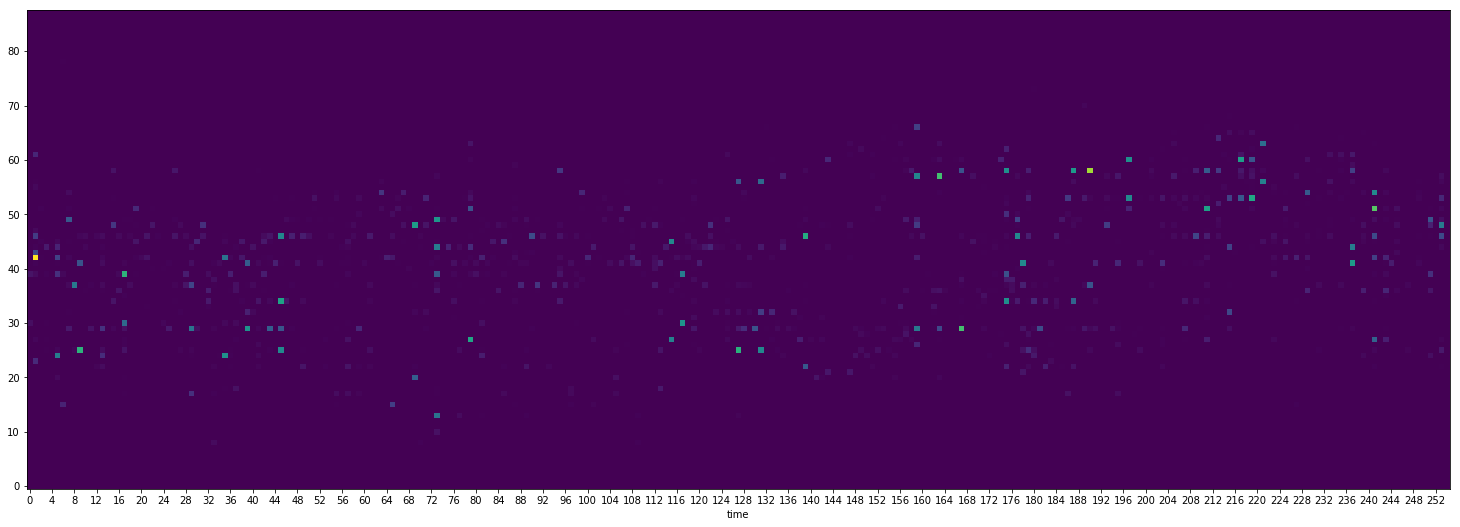

0.00453353  mean for last:  0.0050719


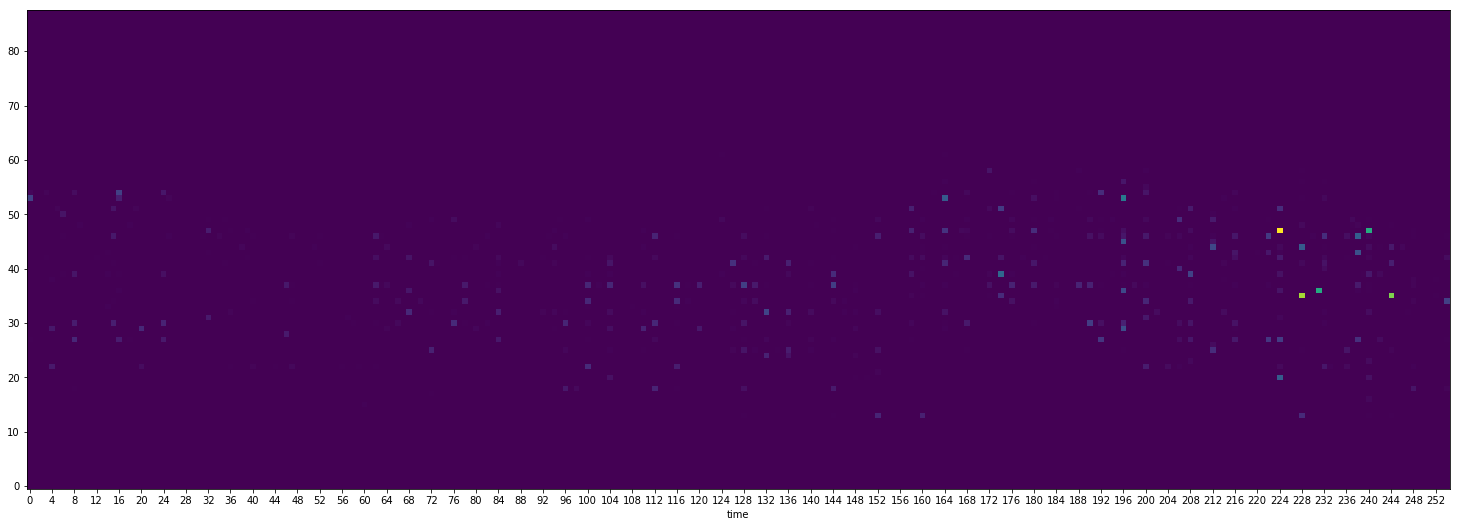

KeyboardInterrupt: 

In [10]:
training_steps = 20000
display_step = 25

losses = []
for step in range(training_steps + 1):
    # getting data
    batch_x = hsongs[np.random.choice(np.arange(len(hsongs)), batch_size)]
    # Run optimization step
    sess.run(train_op, feed_dict={X: batch_x})
    
    L = sess.run(ce, feed_dict={X: batch_x})
    losses.append(L.mean())
    
    if np.isnan(L).any():
        print(" DAMN NAN ERROR")
        break
    
    if step % display_step == 0:
        print(L.mean(), " mean for last: ", np.array(losses)[-display_step:].mean())
        drawNotes(L[0])
        saver.save(sess, "./tmp/300 LSTM CM_dataset songs by fragments 8-history 7-voices (one-time) lr=0.01.ckpt")

print("Optimization Finished!")

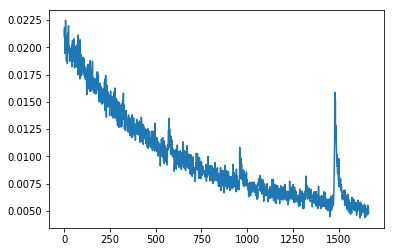

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)

(0, 0.1)

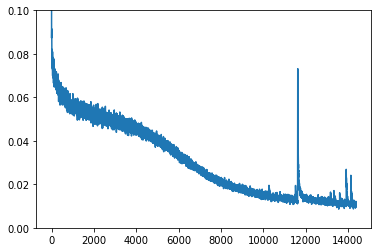

In [38]:
plt.plot(losses)
plt.ylim(0, 0.1)

In [95]:
saver = tf.train.Saver()
saver.save(sess, "./tmp/300 LSTM CM_dataset songs by fragments 8-history 7-voices (one-time) lr=0.01.ckpt")

'./tmp/300 LSTM CM_dataset songs by fragments 8-history 7-voices (one-time) lr=0.01.ckpt'

In [9]:
saver.restore(sess, "./tmp/300 LSTM CM_dataset songs by fragments 8-history 7-voices (one-time) lr=0.01.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/300 LSTM CM_dataset songs by fragments 8-history 7-voices (one-time) lr=0.01.ckpt


In [10]:
import mido
from mido import MidiFile
import numpy as np
import copy
import math

import matplotlib.pyplot as plt
%matplotlib inline

# для возможности прослушивания midi прямо в ноутбуке
HEARING_PORT = mido.open_output()
# для вывода массивов numpy целиком
np.set_printoptions(threshold=np.nan)

BASE_NOTE = 21
KEYS = 88
FREQ = 4  #ticks for beat

def drawSong(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.notes.shape[0] / 10, song.notes.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(song.name)
    plt.imshow(song.notes.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.notes.shape[0], 4))
    plt.show()

# Класс для создания нового миди файла
class MySong:
    def __init__(self, played_lines=[], finished=False):
        self.name = "Generated song!"
        self.notes = np.zeros((0, 88))

        self.mid = MidiFile(type=0)
        self.track = mido.MidiTrack()
        self.mid.tracks.append(self.track)

        self.time_passed = 0
        self.release = []

        for line in played_lines:
            self.add(line)
           
        if finished:
            self.finish()

    # добавление новых строк в ноты
    def add(self, played):
        self.notes = np.vstack([self.notes, played])

        # "отпуск" нот, сыгранных долю назад
        if played.sum() > 0:
            for i in self.release:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=0, time=self.time_passed))
                self.time_passed = 0
            self.release = []

        # добавление новых нот
        for i, key in enumerate(played):
            if key == 1:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
                self.time_passed = 0
                self.release.append(i)
        self.time_passed += self.mid.ticks_per_beat // FREQ

    # должна быть вызвана в конце создания файла
    def finish(self):
        for i in self.release:
            self.track.append(mido.Message('note_off', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.track.append(mido.Message('note_off', note=BASE_NOTE, velocity=0, time=self.time_passed))

    # воспроизведение
    def play(self):
        for msg in self.mid.play():
            HEARING_PORT.send(msg)

    # сохранение
    def save_file(self, name):
        self.mid.save(name + '.mid')

In [23]:
gen = songs[100][:16]

In [24]:
while len(gen) < 128:
    probas = sess.run(voices_proba, feed_dict={X: np.repeat(transform(gen)[None], 125, axis=0)})

    res = np.zeros((88))
    for i in range(voices):
        note = np.random.choice(range(89), p=probas[i][0, -1])
        if note != 88:
            res[note] = 1
            
    gen = np.vstack([gen, res])
    
    print('|', end="")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

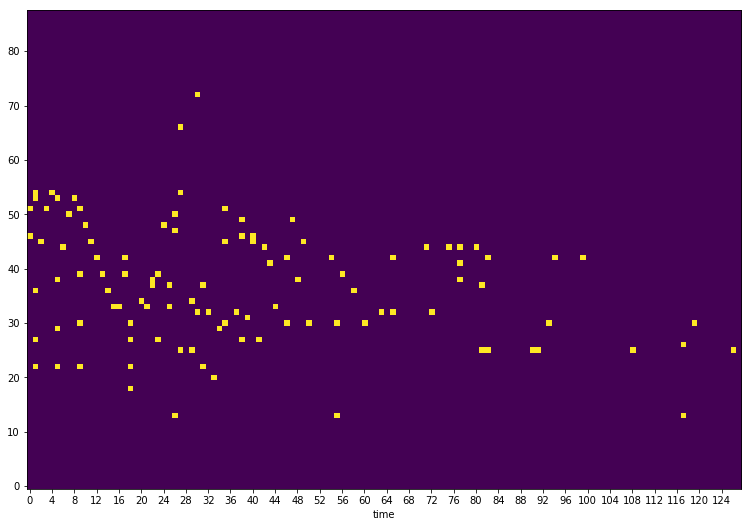

In [30]:
drawNotes(gen)

In [31]:
ms = MySong(gen, finished=True)

In [32]:
ms.play()

In [57]:
#ms.save_file("300 LSTM CM_dataset songs by fragments 8-history 12000 steps lr=0.01")

In [46]:
saver = tf.train.Saver()
saver.save(sess, "./tmp/300 LSTM CM_dataset songs by fragments 8-history 12000 steps lr=0.01.ckpt")

'./tmp/300 LSTM CM_dataset songs by fragments 8-history 12000 steps lr=0.01.ckpt'